In [1]:
pip install torchxrayvision scikit-image 

Note: you may need to restart the kernel to use updated packages.


In [2]:
import cv2 #############
import numpy as np
import torch
import torchxrayvision as xrv
import matplotlib.pyplot as plt

# ================= 1. โหลดโมเดล =================
print("⏳ Loading AI Model...")
# ใช้โมเดล PSPNet จาก torchxrayvision ที่เทรนมาสำหรับ Segmentation โดยเฉพาะ
seg_model = xrv.baseline_models.chestx_det.PSPNet()
seg_model.eval() # ตั้งค่าเป็นโหมดประเมินผล (ไม่เทรนต่อ)
print("✅ AI Model Loaded!")

# ================= 2. ฟังก์ชัน AI Mask =================
def get_ai_lung_mask(img_numpy_uint8):
    """
    รับภาพ X-ray (Grayscale uint8) -> คืนค่า Mask ของปอด (binary image)
    """
    try:
        # 1. Normalize ค่าสี: ปรับช่วงค่าสีให้ตรงกับที่โมเดล xrv ต้องการ (-1024 ถึง 1024 โดยประมาณ)
        img_norm = xrv.datasets.normalize(img_numpy_uint8, 255) 
        
        # 2. Resize: โมเดลนี้ต้องการ input ขนาด 512x512 เท่านั้น
        img_resized = cv2.resize(img_norm, (512, 512))
        
        # 3. Convert to Tensor: แปลงเป็น format [Batch, Channel, Height, Width]
        img_tensor = torch.from_numpy(img_resized)[None, None, ...].float()
        
        # 4. Inference: ให้ AI ทำนาย
        with torch.no_grad(): 
            outputs = seg_model(img_tensor)
        
        # 5. Process Output: 
        # outputs จะออกมาหลาย Channel (เช่น หัวใจ, ปอดซ้าย, ปอดขวา, ฯลฯ)
        pred = outputs[0].numpy()
        
        # index 4 คือ Lung Left, index 5 คือ Lung Right (รวมกันเพื่อให้ได้ปอดทั้งสองข้าง)
        combined_mask = np.maximum(pred[4], pred[5])
        
        # 6. Thresholding: แปลงความน่าจะเป็นให้เป็น 0 หรือ 255 (ขาว/ดำ)
        mask_binary = np.where(combined_mask > 0.5, 255, 0).astype(np.uint8)
        
        # 7. Resize กลับ: ขยาย Mask ให้เท่ากับขนาดภาพต้นฉบับ
        h, w = img_numpy_uint8.shape
        mask_final = cv2.resize(mask_binary, (w, h), interpolation=cv2.INTER_NEAREST)
        
        # 8. Post-processing: ใช้ Morphology ลบจุดรบกวนเล็กๆ และปิดรูโหว่ในปอด
        kernel = np.ones((5,5), np.uint8)
        mask_final = cv2.morphologyEx(mask_final, cv2.MORPH_CLOSE, kernel, iterations=3)
        
        return mask_final
        
    except Exception as e:
        print(f"Error in segmentation: {e}")
        return np.zeros_like(img_numpy_uint8)

# ================= ตัวอย่างการเรียกใช้ =================
# สมมติว่ามีไฟล์ภาพชื่อ 'chest_xray.jpg'
# img = cv2.imread('chest_xray.jpg', cv2.IMREAD_GRAYSCALE)
# if img is not None:
#     lung_mask = get_ai_lung_mask(img)
#     plt.imshow(lung_mask, cmap='gray')
#     plt.show()

c:\Users\b33rt\OneDrive\Desktop\CP xray\Chest xray CP class-20251205T165553Z-3-001\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


⏳ Loading AI Model...
✅ AI Model Loaded!


In [4]:
# ================= 3. ฟังก์ชัน Image Enhancement (CLAHE) ================= ###################
def enhance_lung_clarity(img_gray, lung_mask, clip_limit=2.0, grid_size=(8,8)):
    """
    รับภาพ Grayscale และ Mask -> คืนค่าภาพปอดที่ปรับ Contrast แล้ว (พื้นหลังดำ)
    """
    # 1. สร้าง object CLAHE
    # clip_limit: ค่ายิ่งมาก ภาพยิ่ง contrast จัด (แนะนำ 2.0 - 4.0)
    # tileGridSize: ขนาดตารางที่จะคำนวณแสง (8x8 เป็นค่ามาตรฐาน)
    clahe = cv2.createCLAHE(clipLimit=clip_limit, tileGridSize=grid_size)
    
    # 2. ปรับ Contrast ภาพต้นฉบับ
    enhanced_img = clahe.apply(img_gray)
    
    # 3. ตัดภาพด้วย Mask (เอาเฉพาะส่วนปอด)
    # ใช้ bitwise_and ระหว่างภาพที่ชัดแล้ว กับ Mask
    final_result = cv2.bitwise_and(enhanced_img, enhanced_img, mask=lung_mask)
    
    return final_result

# ================= 4. รวมร่าง (Pipeline) =================
# ส่วนทดสอบการทำงาน (แก้ path ไฟล์ภาพตรงนี้)
# image_path = r"C:\ProjectAi\projectMd8\drive-download-20251203T073447Z-1-001\novap\2286\2286_cxr_novap_20251008_1.jpg" # <--- ใส่ Path ไฟล์ของคุณ

# # 1. โหลดภาพ
# original_img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

# if original_img is not None:
#     print("✅ โหลดภาพสำเร็จ เริ่มประมวลผล...")
    
#     # 2. ทำ Segmentation (ใช้ฟังก์ชันเดิมของคุณ)
#     my_mask = get_ai_lung_mask(original_img)
    
#     # 3. ทำ Enhancement (ใช้ฟังก์ชันใหม่)
#     final_output = enhance_lung_clarity(original_img, my_mask, clip_limit=3.0)
    
#     # 4. แสดงผลเปรียบเทียบ
#     plt.figure(figsize=(15, 6))
    
#     plt.subplot(1, 3, 1)
#     plt.imshow(original_img, cmap='gray')
#     plt.title("1. Original X-ray")
#     plt.axis('off')
    
#     plt.subplot(1, 3, 2)
#     plt.imshow(my_mask, cmap='gray')
#     plt.title("2. AI Mask (Step 1)")
#     plt.axis('off')
    
#     plt.subplot(1, 3, 3)
#     plt.imshow(final_output, cmap='gray')
#     plt.title("3. Final Enhanced Input (Step 2)")
#     plt.axis('off')
    
#     plt.show()
    
#     print("🎉 กระบวนการเตรียมภาพเสร็จสมบูรณ์! พร้อมเข้าสู่ Autoencoder")
# else:
#     print("❌ หาไฟล์ภาพไม่เจอ ตรวจสอบ Path อีกครั้ง")

🚀 เริ่มเตรียม Training Data (Fixed Version)...
🔍 กำลังสแกนหาไฟล์และคัดเลือก Sequence สูงสุด...
📂 พบภาพที่คัดเลือกแล้วทั้งหมด 470 ภาพ


AI Processing: 100%|██████████| 470/470 [19:42<00:00,  2.52s/it]


✅ ประมวลผลเสร็จสิ้น! ได้ข้อมูลขนาด: (470, 256, 256, 1)
💾 บันทึกไฟล์เรียบร้อย!


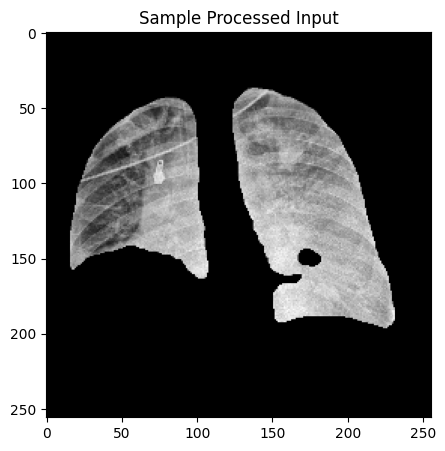

In [8]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import glob

# ================= ฟังก์ชันคัดเลือกไฟล์ (แก้ไขแล้ว) =================
def get_best_sequence_files(patient_folder):
    """
    input: โฟลเดอร์ของคนไข้ 1 คน
    output: รายชื่อไฟล์ .jpg ที่คัดมาแล้ว (เฉพาะ Path)
    """
    files = glob.glob(os.path.join(patient_folder, "*.jpg"))
    daily_files = {} # dict เก็บ { '20250808': (seq, filepath) }

    for f in files:
        try:
            filename = os.path.basename(f)
            parts = filename.replace(".jpg", "").split("_")
            
            if len(parts) < 2: continue 

            date_str = parts[-2] 
            seq_num = int(parts[-1]) 

            # Logic: เก็บ seq และ filepath คู่กัน
            if date_str not in daily_files or seq_num > daily_files[date_str][0]:
                daily_files[date_str] = (seq_num, f)
        except Exception as e:
            continue

    # ⚠️ แก้ไขจุดนี้: ดึงเฉพาะ filepath (item[1][1]) ออกมา ไม่เอา seq (item[1][0])
    # item structure from .items(): (date_key, (seq, filepath))
    return [item[1][1] for item in sorted(daily_files.items())]

# ================= 5. ฟังก์ชันเตรียม Dataset (Structure Version) =================
def prepare_dataset_structure(root_path, img_size=(256, 256), limit=None):
    processed_images = []
    classes = ["novap", "vap"]
    
    all_tasks = []
    print("🔍 กำลังสแกนหาไฟล์และคัดเลือก Sequence สูงสุด...")
    
    for cls in classes:
        class_path = os.path.join(root_path, cls)
        if not os.path.exists(class_path): continue
        
        patient_ids = os.listdir(class_path)
        for pid in patient_ids:
            patient_path = os.path.join(class_path, pid)
            if not os.path.isdir(patient_path): continue
            
            # ใช้ฟังก์ชันที่แก้แล้ว
            selected_files = get_best_sequence_files(patient_path)
            all_tasks.extend(selected_files)

    if limit:
        all_tasks = all_tasks[:limit]

    print(f"📂 พบภาพที่คัดเลือกแล้วทั้งหมด {len(all_tasks)} ภาพ")

    for full_path in tqdm(all_tasks, desc="AI Processing"):
        try:
            # 1. โหลดภาพ (ตอนนี้ full_path จะเป็น string path ที่ถูกต้องแล้ว)
            img = cv2.imread(full_path, cv2.IMREAD_GRAYSCALE)
            if img is None: continue
                
            # 2. AI Segmentation (ต้องมีฟังก์ชันเดิมใน Memory)
            mask = get_ai_lung_mask(img)
            
            if np.sum(mask) == 0: continue
                
            # 3. Enhancement (ต้องมีฟังก์ชันเดิมใน Memory)
            enhanced = enhance_lung_clarity(img, mask)
            
            # 4. Resize & Normalize
            resized = cv2.resize(enhanced, img_size)
            normalized = resized.astype('float32') / 255.0
            
            processed_images.append(normalized)
            
        except Exception as e:
            print(f"⚠️ Error processing {full_path}: {e}")
            continue

    if len(processed_images) == 0:
        print("❌ ไม่สำเร็จสักรูปเลย!")
        return np.array([])

    dataset_array = np.array(processed_images)
    dataset_array = np.expand_dims(dataset_array, axis=-1)
    
    print(f"✅ ประมวลผลเสร็จสิ้น! ได้ข้อมูลขนาด: {dataset_array.shape}")
    return dataset_array

# ================= 6. เริ่มรันเตรียมข้อมูลจริง =================
root_folder = "Chest xray CP class"  

if os.path.exists(root_folder):
    print("🚀 เริ่มเตรียม Training Data (Fixed Version)...")
    
    X_train = prepare_dataset_structure(root_folder, img_size=(256, 256))
    
    if len(X_train) > 0:
        np.save("x_train_lungs_structured.npy", X_train)
        print("💾 บันทึกไฟล์เรียบร้อย!")
        
        plt.figure(figsize=(5,5))
        plt.imshow(X_train[0].reshape(256, 256), cmap='gray') 
        plt.title("Sample Processed Input")
        plt.show()
else:
    print(f"❌ หาโฟลเดอร์ไม่เจอ: {root_folder}")

Stable Diffusion

In [9]:
pip install diffusers accelerate transformers scipy safetensors

Note: you may need to restart the kernel to use updated packages.


🚀 Training Diffusion on: cpu
⏳ Loading data from x_train_lungs_structured.npy ...
✅ Data Ready! Size: (470, 1, 128, 128)
🔥 Start Training Diffusion...
Epoch 1/30 | Loss: 0.82838
Epoch 2/30 | Loss: 0.17369
Epoch 3/30 | Loss: 0.06025
Epoch 4/30 | Loss: 0.04795
Epoch 5/30 | Loss: 0.04168
Epoch 6/30 | Loss: 0.03491
Epoch 7/30 | Loss: 0.02593
Epoch 8/30 | Loss: 0.02127
Epoch 9/30 | Loss: 0.01684
Epoch 10/30 | Loss: 0.02176
Epoch 11/30 | Loss: 0.01492
Epoch 12/30 | Loss: 0.01528
Epoch 13/30 | Loss: 0.01305
Epoch 14/30 | Loss: 0.01369
Epoch 15/30 | Loss: 0.01157
Epoch 16/30 | Loss: 0.01697
Epoch 17/30 | Loss: 0.01682
Epoch 18/30 | Loss: 0.01282
Epoch 19/30 | Loss: 0.01177
Epoch 20/30 | Loss: 0.01024
Epoch 21/30 | Loss: 0.01556
Epoch 22/30 | Loss: 0.01513
Epoch 23/30 | Loss: 0.01163
Epoch 24/30 | Loss: 0.01472
Epoch 25/30 | Loss: 0.01196
Epoch 26/30 | Loss: 0.01076
Epoch 27/30 | Loss: 0.01248
Epoch 28/30 | Loss: 0.01150
Epoch 29/30 | Loss: 0.01090
Epoch 30/30 | Loss: 0.01020
💾 Model Saved to f

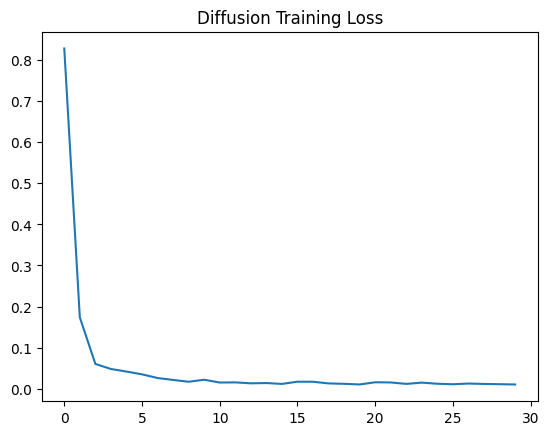

In [12]:
import torch
import torch.nn.functional as F
from diffusers import DDPMScheduler, UNet2DModel
from diffusers.optimization import get_cosine_schedule_with_warmup
import numpy as np
from torch.utils.data import DataLoader, TensorDataset
import os
import matplotlib.pyplot as plt

# ================= 1. Config (ปรับตามคอมคุณ) =================
DATA_PATH = "x_train_lungs_structured.npy" # ✅ ใช้ไฟล์เดิมได้เลย
BATCH_SIZE = 8       # Diffusion กิน VRAM เยอะ ถ้า Error ให้ลดเหลือ 4 หรือ 2
IMG_SIZE = 128       # ⚠️ แนะนำลดจาก 256 เหลือ 128 ก่อนครับ (Diffusion 256 กินสเปคโหดมาก)
EPOCHS = 30          # Diffusion เรียนรู้ช้ากว่า AE อาจต้องรันนานหน่อย
LEARNING_RATE = 1e-4

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"🚀 Training Diffusion on: {device}")

# ================= 2. เตรียมข้อมูล (Load & Resize) =================
print(f"⏳ Loading data from {DATA_PATH} ...")
data = np.load(DATA_PATH) 

# Resize ข้อมูลลงหน่อยเพื่อความลื่นไหล (จาก 256 -> 128)
# ถ้าการ์ดจอคุณแรง (VRAM 12GB+) จะใช้ 256 เท่าเดิมก็ได้ครับ
import cv2
data_resized = []
for img in data:
    # img shape เดิมคือ (256, 256, 1)
    resized = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
    data_resized.append(resized)

data = np.array(data_resized)
data = np.expand_dims(data, axis=1) # แปลงเป็น (N, 1, 128, 128)

# สร้าง DataLoader
dataset = TensorDataset(torch.Tensor(data))
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)
print(f"✅ Data Ready! Size: {data.shape}")

# ================= 3. สร้าง Model & Noise Scheduler =================
# Scheduler: ตัวกำหนดจังหวะการใส่ Noise (1000 ขั้นตอน)
noise_scheduler = DDPMScheduler(num_train_timesteps=1000)

# Model: U-Net (หัวใจของ Stable Diffusion)
model = UNet2DModel(
    sample_size=IMG_SIZE,
    in_channels=1,     # ขาวดำ
    out_channels=1,    # ขาวดำ
    layers_per_block=2,
    block_out_channels=(64, 128, 256, 256), # จำนวน Filter
    down_block_types=(
        "DownBlock2D", 
        "DownBlock2D", 
        "AttnDownBlock2D", # ใส่ Attention เพื่อให้จำ Texture เก่งๆ
        "DownBlock2D"
    ),
    up_block_types=(
        "UpBlock2D", 
        "AttnUpBlock2D", 
        "UpBlock2D", 
        "UpBlock2D"
    ),
).to(device)

optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE)
lr_scheduler = get_cosine_schedule_with_warmup(
    optimizer=optimizer,
    num_warmup_steps=500,
    num_training_steps=len(dataloader) * EPOCHS,
)

# ================= 4. เริ่มเทรน (Training Loop) =================
print("🔥 Start Training Diffusion...")
loss_history = []

for epoch in range(EPOCHS):
    epoch_loss = 0.0
    for step, batch in enumerate(dataloader):
        clean_images = batch[0].to(device)
        
        # A. สร้าง Noise
        noise = torch.randn(clean_images.shape).to(device)
        bs = clean_images.shape[0]
        
        # B. สุ่ม Timestep (เลือกว่าจะใส่ Noise ระดับไหน)
        timesteps = torch.randint(0, noise_scheduler.config.num_train_timesteps, (bs,), device=device).long()
        
        # C. ใส่ Noise เข้าไปในภาพ (Forward Diffusion)
        noisy_images = noise_scheduler.add_noise(clean_images, noise, timesteps)
        
        # D. ให้ AI ทายว่า "Noise หน้าตาเป็นยังไง"
        noise_pred = model(noisy_images, timesteps, return_dict=False)[0]
        
        # E. คำนวณ Loss (เทียบ Noise จริง vs Noise ที่ทาย)
        loss = F.mse_loss(noise_pred, noise)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        lr_scheduler.step()
        
        epoch_loss += loss.item()
        
    avg_loss = epoch_loss / len(dataloader)
    loss_history.append(avg_loss)
    print(f"Epoch {epoch+1}/{EPOCHS} | Loss: {avg_loss:.5f}")

# ================= 5. บันทึกโมเดล =================
# เซฟแบบ HuggingFace format (ใช้ง่ายมากตอนโหลด)
model.save_pretrained("lung_diffusion_model")
print("💾 Model Saved to folder 'lung_diffusion_model'")

# ดูกราฟ
plt.plot(loss_history)
plt.title("Diffusion Training Loss")
plt.show()

🚀 Inference on: cpu
⏳ Loading model from lung_diffusion_model...
✅ Model loaded!
🎨 Generating 5 images from pure noise...


Denoising steps: 100%|██████████| 1000/1000 [38:53<00:00,  2.33s/it]


✨ Generation finished!
⏳ Loading real images for comparison...


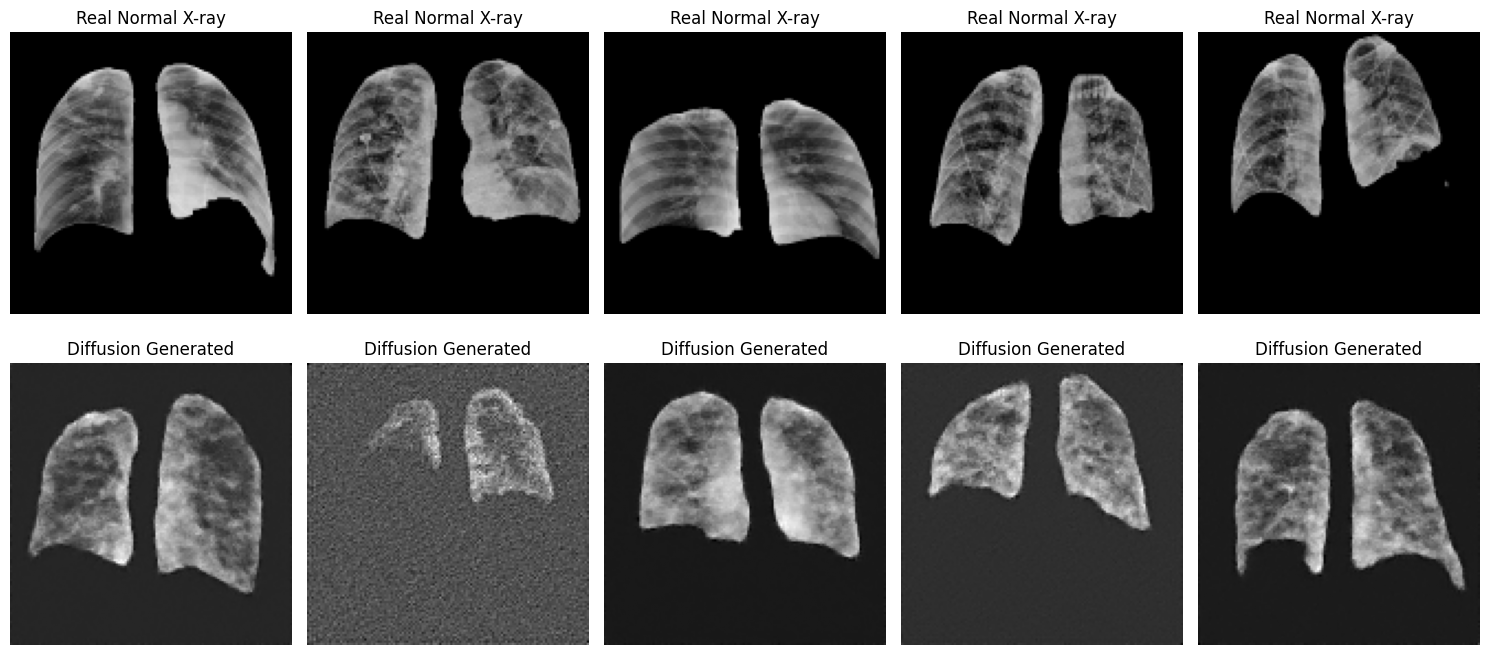

In [15]:
import torch
from diffusers import DDPMScheduler, UNet2DModel
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import cv2
import os

# ================= 1. Config =================
MODEL_PATH = "lung_diffusion_model" # โฟลเดอร์ที่เก็บโมเดล
DATA_PATH = "x_train_lungs_structured.npy"     # ไฟล์ข้อมูลจริงเอามาเปรียบเทียบ
IMG_SIZE = 128       # ต้องตรงกับตอนเทรน!
N_SAMPLES = 5        # จำนวนภาพที่จะสร้าง
device = "cuda" if torch.cuda.is_available() else "cpu"

print(f"🚀 Inference on: {device}")

# ================= 2. โหลด Model และ Scheduler =================
# สร้าง Scheduler ตัวเดิม (กำหนดจังหวะการแก้ Noise 1000 step)
noise_scheduler = DDPMScheduler(num_train_timesteps=1000)

# โหลด U-Net ที่เทรนเสร็จแล้ว
if os.path.exists(MODEL_PATH):
    print(f"⏳ Loading model from {MODEL_PATH}...")
    model = UNet2DModel.from_pretrained(MODEL_PATH).to(device)
    model.eval()
    print("✅ Model loaded!")
else:
    raise FileNotFoundError(f"❌ หาโฟลเดอร์ {MODEL_PATH} ไม่เจอ (เทรนเสร็จรึยังครับ?)")

# ================= 3. ขั้นตอนการสร้างภาพ (The Magic!) =================
print(f"🎨 Generating {N_SAMPLES} images from pure noise...")

# A. เริ่มต้นด้วยภาพ Noise ล้วนๆ (สุ่มจาก Normal Distribution)
# Shape: (5, 1, 128, 128)
generated_images = torch.randn((N_SAMPLES, 1, IMG_SIZE, IMG_SIZE)).to(device)

# B. วนลูปย้อนกลับ (Reverse Diffusion Process)
# จาก Timestep 999 ถอยหลังมาถึง 0 (ค่อยๆ แกะ Noise ออกทีละนิด)
for t in tqdm(noise_scheduler.timesteps, desc="Denoising steps"):
    with torch.no_grad():
        # 1. ให้ AI ทำนายว่า "Noise ณ ตอนนี้ หน้าตาเป็นไง"
        model_output = model(generated_images, t).sample
        
        # 2. ใช้ Scheduler คำนวณภาพขั้นถัดไป (ที่ Noise น้อยลง)
        # สูตร: ภาพเดิม - (Noise ที่ทาย * ตัวคูณ)
        generated_images = noise_scheduler.step(model_output, t, generated_images).prev_sample

print("✨ Generation finished!")

# ================= 4. เตรียมภาพสำหรับแสดงผล =================
# ย้ายมา CPU และแปลงเป็น Numpy
generated_imgs_np = generated_images.cpu().numpy()

# Post-processing: ปรับค่าสีให้เหมาะกับการแสดงผล
# เนื่องจาก Diffusion output อาจมีค่าติดลบหรือเกิน 1 เราต้อง Normalize ใหม่
processed_gen_imgs = []
for img in generated_imgs_np:
    img = img[0] # ดึง Channel ออก (128, 128)
    # Normalize ให้อยู่ช่วง 0-1 แบบง่ายๆ
    img = (img - img.min()) / (img.max() - img.min())
    processed_gen_imgs.append(img)

# ================= 5. โหลดภาพจริงมาเปรียบเทียบ =================
print("⏳ Loading real images for comparison...")
real_data = np.load(DATA_PATH)
# สุ่มมา 5 รูป แล้ว Resize เหลือ 128 เพื่อให้เทียบเท่ากัน
real_samples = []
indices = np.random.choice(len(real_data), N_SAMPLES, replace=False)
for idx in indices:
    img_256 = real_data[idx].reshape(256, 256)
    img_128 = cv2.resize(img_256, (IMG_SIZE, IMG_SIZE))
    real_samples.append(img_128)

# ================= 6. แสดงผล (Plotting) =================
plt.figure(figsize=(15, 7))

for i in range(N_SAMPLES):
    # --- แถวบน: ภาพจริง (Real Normal) ---
    plt.subplot(2, N_SAMPLES, i + 1)
    plt.imshow(real_samples[i], cmap='gray', vmin=0, vmax=1)
    plt.title("Real Normal X-ray")
    plt.axis('off')

    # --- แถวล่าง: ภาพที่ AI สร้าง (AI Generated) ---
    plt.subplot(2, N_SAMPLES, i + 1 + N_SAMPLES)
    plt.imshow(processed_gen_imgs[i], cmap='gray', vmin=0, vmax=1)
    plt.title("Diffusion Generated")
    plt.axis('off')

plt.tight_layout()
plt.show()

🔧 Reconstructing image index 0...


Repairing image: 100%|██████████| 51/51 [00:23<00:00,  2.15it/s]


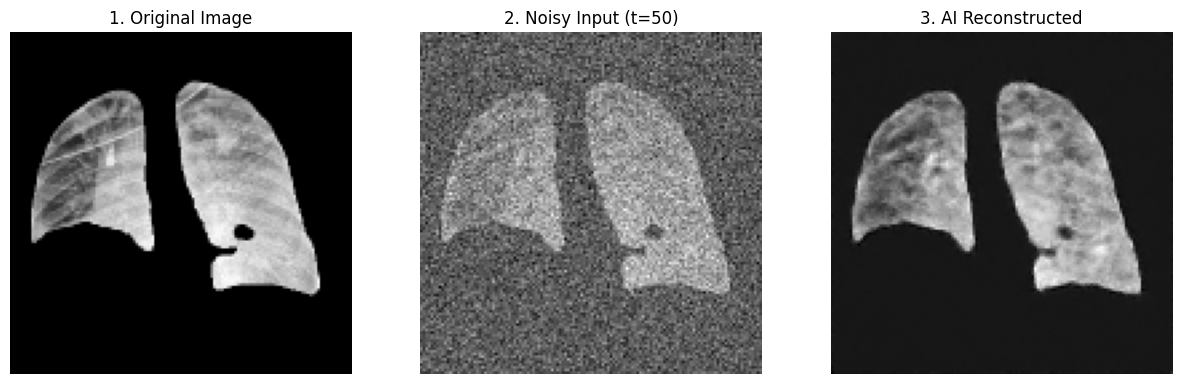

In [17]:
import torch
from diffusers import DDPMScheduler, UNet2DModel
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import cv2
import os

# ================= 1. Config =================
MODEL_PATH = "lung_diffusion_model"
DATA_PATH = "x_train_lungs_structured.npy"
IMG_SIZE = 128
START_TIMESTEP = 50  # ⚡ จุดสำคัญ: เริ่มที่ 500/1000 (ใส่ Noise 50%)
# ถ้าอยากให้เพี้ยนน้อยลง ให้ลดเหลือ 300
# ถ้าอยากให้ AI วาดใหม่เยอะๆ ให้เพิ่มเป็น 700

device = "cuda" if torch.cuda.is_available() else "cpu"

# ================= 2. โหลด Model & Data =================
noise_scheduler = DDPMScheduler(num_train_timesteps=1000)
model = UNet2DModel.from_pretrained(MODEL_PATH).to(device)
model.eval()

# โหลดภาพจริงมา 1 รูป (เอา index ที่ 0 หรือเปลี่ยนเลขเพื่อเลือกรูปอื่น)
data = np.load(DATA_PATH)
target_idx = 0 
original_img_raw = data[target_idx] # (256, 256, 1)

# Resize & Prepare Tensor
img_resized = cv2.resize(original_img_raw, (IMG_SIZE, IMG_SIZE))
# แปลงเป็น Tensor (1, 1, 128, 128) และย้ายไป GPU
input_image = torch.tensor(img_resized).unsqueeze(0).unsqueeze(0).to(device)

# ================= 3. ขั้นตอน "ทำลายแล้วสร้างใหม่" =================
print(f"🔧 Reconstructing image index {target_idx}...")

# A. สร้าง Noise
noise = torch.randn(input_image.shape).to(device)

# B. ใส่ Noise เข้าไปในภาพจริง (Forward Process) ที่ระดับ START_TIMESTEP
# ผลลัพธ์คือภาพที่ "ซ่าๆ" แต่ยังมีเค้าโครงเดิม
timesteps = torch.tensor([START_TIMESTEP], device=device).long()
noisy_image = noise_scheduler.add_noise(input_image, noise, timesteps)

# C. ให้ AI ซ่อมภาพกลับคืน (Reverse Process)
# เริ่มวนลูปจาก START_TIMESTEP ถอยหลังไปจนถึง 0
current_image = noisy_image

# กำหนดช่วงเวลาที่จะวนลูป (เช่น 500 -> 0)
scheduler_timesteps = noise_scheduler.timesteps
# ตัดเอาเฉพาะช่วงที่เราต้องการ (ข้ามช่วง 1000-501 ไป)
start_index = (scheduler_timesteps == START_TIMESTEP).nonzero(as_tuple=True)[0].item()
subset_timesteps = scheduler_timesteps[start_index:]

for t in tqdm(subset_timesteps, desc="Repairing image"):
    with torch.no_grad():
        # 1. ทาย Noise
        model_output = model(current_image, t).sample
        
        # 2. ลบ Noise ออก (ซ่อมภาพ)
        current_image = noise_scheduler.step(model_output, t, current_image).prev_sample

# ================= 4. แสดงผลเปรียบเทียบ =================
# แปลงกลับเป็น Numpy เพื่อโชว์
def process_for_show(tensor):
    img = tensor.cpu().numpy()[0, 0]
    return (img - img.min()) / (img.max() - img.min())

img_original = process_for_show(input_image)
img_noisy = process_for_show(noisy_image)
img_reconstructed = process_for_show(current_image)

plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.imshow(img_original, cmap='gray')
plt.title("1. Original Image")
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(img_noisy, cmap='gray')
plt.title(f"2. Noisy Input (t={START_TIMESTEP})")
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(img_reconstructed, cmap='gray')
plt.title("3. AI Reconstructed")
plt.axis('off')

plt.show()

✅ Auto-selected image: Chest xray CP class\novap\2268\2268_cxr_novap_20251001_1.jpg
🔎 Scanning image: Chest xray CP class\novap\2268\2268_cxr_novap_20251001_1.jpg
🔧 AI Repairing...


Denoising: 100%|██████████| 101/101 [00:42<00:00,  2.35it/s]


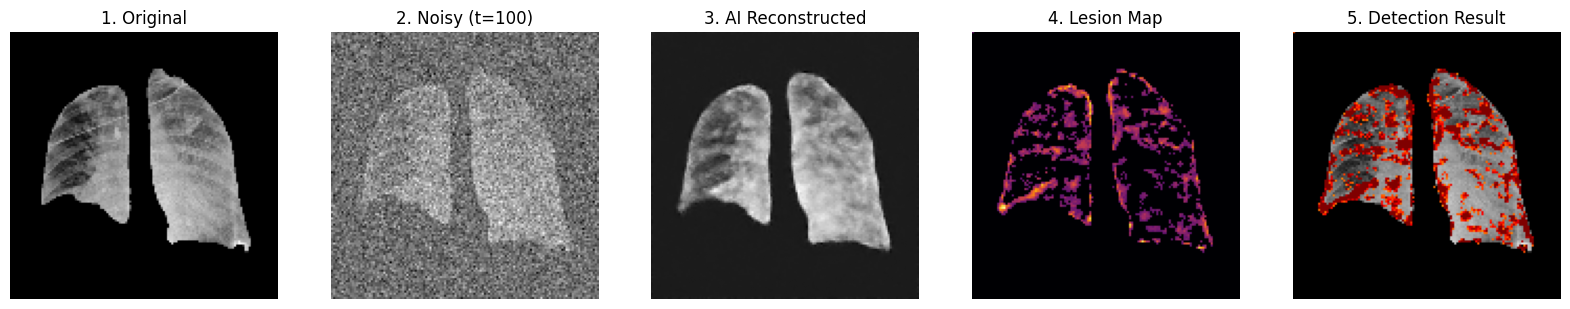

In [20]:
import torch
from diffusers import DDPMScheduler, UNet2DModel
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import cv2
import os
import glob

# ================= 1. Config =================
# ⚠️ กำหนด Path โฟลเดอร์หลัก
ROOT_DIR = "Chest xray CP class"

# ฟังก์ชันช่วยหาไฟล์ภาพอัตโนมัติ (จะได้ไม่ต้องแก้ Path ยาวๆ เอง)
def find_test_image(root_folder):
    # ลองหาภาพแรกที่เจอในโฟลเดอร์ (ค้นหาแบบลึก)
    search_path = os.path.join(root_folder, "**", "*.jpg")
    found_files = glob.glob(search_path, recursive=True)
    
    if found_files:
        return found_files[0] # คืนค่าไฟล์แรกที่เจอ
    else:
        return None

# ตั้งค่า TEST_IMAGE_PATH
# 1. ลองหาไฟล์อัตโนมัติ
auto_image = find_test_image(ROOT_DIR)

if auto_image:
    TEST_IMAGE_PATH = auto_image
    print(f"✅ Auto-selected image: {TEST_IMAGE_PATH}")
else:
    # 2. ถ้าหาไม่เจอ ให้ใส่ Path เองตรงนี้
    TEST_IMAGE_PATH = r"path/to/your/image.jpg"
    print("⚠️ ไม่เจอไฟล์ในโฟลเดอร์ Chest xray CP class กรุณาเช็ค path")

MODEL_PATH = "lung_diffusion_model"
IMG_SIZE = 128
START_TIMESTEP = 100
THRESHOLD = 0.15

device = "cuda" if torch.cuda.is_available() else "cpu"

# ================= 2. เตรียม Model & ฟังก์ชัน =================
# (ส่วนนี้เหมือนเดิม)
noise_scheduler = DDPMScheduler(num_train_timesteps=1000)
try:
    model = UNet2DModel.from_pretrained(MODEL_PATH).to(device)
    model.eval()
except OSError:
    print(f"❌ ไม่เจอโฟลเดอร์โมเดล '{MODEL_PATH}' กรุณาเช็คว่ารันการ Train หรือยัง")
    model = None

def process_image(img_path):
    if not os.path.exists(img_path):
        return None
        
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    if img is None: return None
    
    # Check for helper functions
    try:
        if 'get_ai_lung_mask' in globals() and 'enhance_lung_clarity' in globals():
            mask = get_ai_lung_mask(img)
            enhanced = enhance_lung_clarity(img, mask)
        else:
            print("⚠️ Warning: ไม่เจอฟังก์ชันตัดปอด (ใช้ภาพดิบแทน)")
            enhanced = img
    except Exception as e:
        print(f"⚠️ Error in preprocessing: {e}")
        enhanced = img

    resized = cv2.resize(enhanced, (IMG_SIZE, IMG_SIZE))
    img_tensor = torch.tensor(resized).float() / 255.0
    return img_tensor.unsqueeze(0).unsqueeze(0).to(device), resized

# ================= 3. เริ่มกระบวนการสแกน (แก้ไขจุด Error) =================
if model is not None and TEST_IMAGE_PATH and os.path.exists(TEST_IMAGE_PATH):
    print(f"🔎 Scanning image: {TEST_IMAGE_PATH}")
    
    # 🔥 แก้ไขจุด Error ตรงนี้: รับค่ามาก่อน แล้วค่อยเช็ค
    process_result = process_image(TEST_IMAGE_PATH)
    
    if process_result is not None:
        # แตกตัวแปรเมื่อมั่นใจว่ามีของ
        input_tensor, original_img_np = process_result
        
        # A. ใส่ Noise
        noise = torch.randn(input_tensor.shape).to(device)
        timesteps = torch.tensor([START_TIMESTEP], device=device).long()
        noisy_image = noise_scheduler.add_noise(input_tensor, noise, timesteps)
        
        # B. ซ่อมภาพ
        current_image = noisy_image
        scheduler_timesteps = noise_scheduler.timesteps
        start_index = (scheduler_timesteps == START_TIMESTEP).nonzero(as_tuple=True)[0].item()
        subset_timesteps = scheduler_timesteps[start_index:]
        
        print("🔧 AI Repairing...")
        for t in tqdm(subset_timesteps, desc="Denoising"):
            with torch.no_grad():
                model_output = model(current_image, t).sample
                current_image = noise_scheduler.step(model_output, t, current_image).prev_sample

        # ================= 4. วิเคราะห์ผลลัพธ์ =================
        img_recon = current_image.cpu().numpy()[0, 0]
        img_orig = input_tensor.cpu().numpy()[0, 0]
        
        img_recon = (img_recon - img_recon.min()) / (img_recon.max() - img_recon.min())
        diff = np.abs(img_orig - img_recon)
        
        # Post-processing
        img_orig_blur = cv2.GaussianBlur(img_orig, (3, 3), 0)
        diff_clean = np.abs(img_orig_blur - img_recon)
        lesion_map = np.where(diff_clean > THRESHOLD, diff_clean, 0)
        
        heatmap_display = np.clip(lesion_map * 5, 0, 1)
        heatmap_color = cv2.applyColorMap((heatmap_display * 255).astype(np.uint8), cv2.COLORMAP_JET)
        
        orig_bgr = cv2.cvtColor((img_orig * 255).astype(np.uint8), cv2.COLOR_GRAY2BGR)
        mask_lesion = (heatmap_display > 0).astype(np.uint8) * 255
        bg = cv2.bitwise_and(orig_bgr, orig_bgr, mask=cv2.bitwise_not(mask_lesion))
        fg = cv2.bitwise_and(heatmap_color, heatmap_color, mask=mask_lesion)
        overlay = cv2.add(bg, fg)

        # ================= 5. แสดงกราฟ =================
        plt.figure(figsize=(20, 5))
        
        plt.subplot(1, 5, 1); plt.imshow(img_orig, cmap='gray'); plt.title("1. Original"); plt.axis('off')
        
        noisy_show = noisy_image.cpu().numpy()[0, 0]
        plt.subplot(1, 5, 2); plt.imshow(noisy_show, cmap='gray'); plt.title(f"2. Noisy (t={START_TIMESTEP})"); plt.axis('off')
        
        plt.subplot(1, 5, 3); plt.imshow(img_recon, cmap='gray'); plt.title("3. AI Reconstructed"); plt.axis('off')
        plt.subplot(1, 5, 4); plt.imshow(lesion_map, cmap='inferno'); plt.title("4. Lesion Map"); plt.axis('off')
        plt.subplot(1, 5, 5); plt.imshow(cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB)); plt.title("5. Detection Result"); plt.axis('off')
        
        plt.show()
    else:
        print("❌ Error: process_image returned None (อ่านไฟล์ไม่ได้)")
else:
    print(f"❌ Error: หาไฟล์ภาพไม่เจอที่: {TEST_IMAGE_PATH}")
    print(f"หรือยังไม่ได้โหลด Model: {MODEL_PATH}")

🔄 กำลังเปรียบเทียบอาการ...
📅 Day 1: 2268_cxr_novap_20251001_1.jpg
📅 Day 2: 2268_cxr_novap_20251002_1.jpg

📊 ผลลัพธ์:
   - คะแนน Day 1: 88.62%
   - คะแนน Day 2: 86.34%
   - สรุป: ✅ อาการดีขึ้น (Improved) (-2.28%)


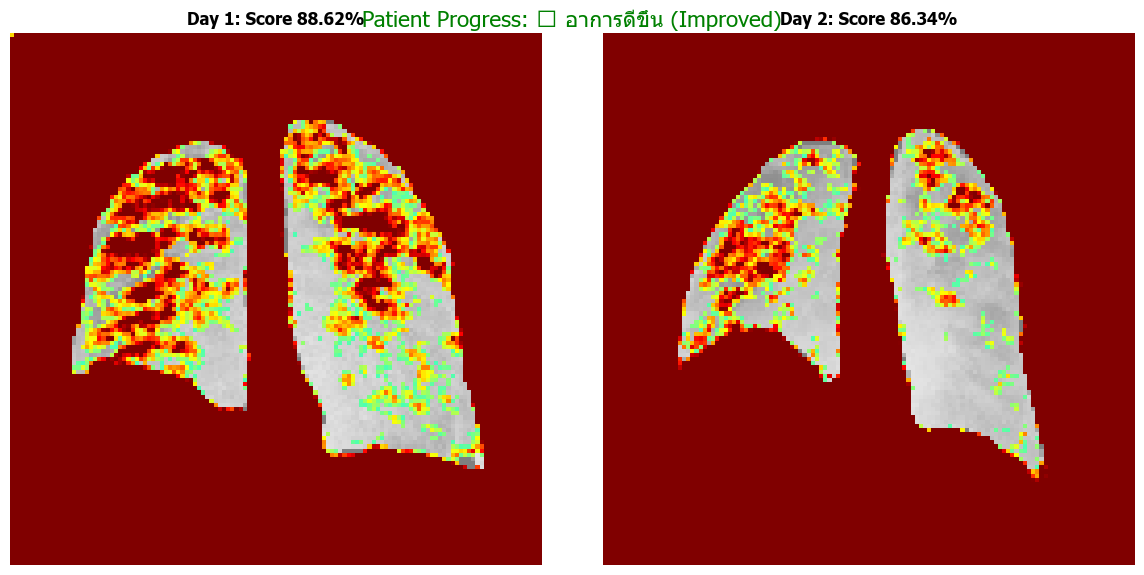

In [21]:
# ==============================================================================
# 🎯 ส่วนเสริม: ฟังก์ชันเปรียบเทียบอาการ (Day 1 vs Day 2)
# ==============================================================================
import matplotlib.pyplot as plt
# เพิ่มบรรทัดนี้
plt.rcParams['font.family'] = 'Tahoma'

def analyze_lesion_score(img_path, model, scheduler, start_timestep=200, threshold=0.25):
    """
    เวอร์ชันอัปเกรด: ตัดพื้นหลังทิ้ง + ลดความไวต่อกระดูก
    """
    # 1. เตรียมภาพ
    input_tensor, original_img_np = process_image(img_path)
    if input_tensor is None: return None, 0.0

    # 2. ใส่ Noise (เพิ่ม Timestep เป็น 350 เพื่อให้ AI จำโครงสร้างกระดูกแม่นขึ้น)
    noise = torch.randn(input_tensor.shape).to(device)
    timesteps = torch.tensor([start_timestep], device=device).long()
    noisy_image = scheduler.add_noise(input_tensor, noise, timesteps)

    # 3. ซ่อมภาพ
    current_image = noisy_image
    scheduler_timesteps = scheduler.timesteps
    start_index = (scheduler_timesteps == start_timestep).nonzero(as_tuple=True)[0].item()
    subset_timesteps = scheduler_timesteps[start_index:]

    for t in subset_timesteps:
        with torch.no_grad():
            model_output = model(current_image, t).sample
            current_image = scheduler.step(model_output, t, current_image).prev_sample

    # 4. คำนวณความต่าง
    img_recon = current_image.cpu().numpy()[0, 0]
    img_orig = input_tensor.cpu().numpy()[0, 0]
    
    # แปลงช่วงข้อมูลให้เป็น 0-1 เหมือนกัน
    img_orig = (img_orig + 1) / 2
    img_recon = (img_recon - img_recon.min()) / (img_recon.max() - img_recon.min())
    
    # Post-process
    img_orig_blur = cv2.GaussianBlur(img_orig, (3, 3), 0)
    diff_clean = np.abs(img_orig_blur - img_recon)
    
    # --- 🛠️ 1. ล้างพื้นหลังทิ้ง (Background Cleaning) ---
    # สร้าง Mask จากภาพต้นฉบับ: ตรงไหนที่ต้นฉบับมืดมาก (พื้นหลัง) ให้ค่าความต่างเป็น 0 ไปเลย
    background_mask = np.where(img_orig < 0.1, 0, 1) 
    diff_clean = diff_clean * background_mask # คูณ Mask เข้าไป พื้นหลังจะหายวับ!
    
    # --- 🛠️ 2. กรองกระดูกออก (Thresholding) ---
    # ปรับเป็น 0.25 หรือ 0.30 เพื่อข้ามซี่โครง
    lesion_map = np.where(diff_clean > threshold, diff_clean, 0)

    # 5. คำนวณคะแนน
    lesion_pixels = np.count_nonzero(lesion_map)
    lung_pixels = np.count_nonzero(img_orig > 0.1)
    
    if lung_pixels == 0: score = 0.0
    else: score = (lesion_pixels / lung_pixels) * 100

    # 6. สร้างภาพ Overlay
    heatmap_display = np.clip(lesion_map * 3, 0, 1) # ลดความจัดจ้านลง
    heatmap_color = cv2.applyColorMap((heatmap_display * 255).astype(np.uint8), cv2.COLORMAP_JET)
    
    orig_bgr = cv2.cvtColor((img_orig * 255).astype(np.uint8), cv2.COLOR_GRAY2BGR)
    
    mask_lesion = (heatmap_display > 0).astype(np.uint8) * 255
    bg = cv2.bitwise_and(orig_bgr, orig_bgr, mask=cv2.bitwise_not(mask_lesion))
    fg = cv2.bitwise_and(heatmap_color, heatmap_color, mask=mask_lesion)
    overlay = cv2.add(bg, fg)

    return overlay, score

def compare_progress(path_day1, path_day2, model, scheduler):
    print(f"🔄 กำลังเปรียบเทียบอาการ...")
    print(f"📅 Day 1: {os.path.basename(path_day1)}")
    print(f"📅 Day 2: {os.path.basename(path_day2)}")

    # วิเคราะห์ Day 1
    overlay1, score1 = analyze_lesion_score(path_day1, model, scheduler, START_TIMESTEP, THRESHOLD)
    if overlay1 is None: 
        print("❌ Error reading Day 1 image"); return

    # วิเคราะห์ Day 2
    overlay2, score2 = analyze_lesion_score(path_day2, model, scheduler, START_TIMESTEP, THRESHOLD)
    if overlay2 is None:
        print("❌ Error reading Day 2 image"); return

    # คำนวณความเปลี่ยนแปลง
    diff_score = score2 - score1
    
    # สรุปผล
    if diff_score < -1.0:
        status = "✅ อาการดีขึ้น (Improved)"
        color = 'green'
    elif diff_score > 1.0:
        status = "❌ อาการแย่ลง (Worsened)"
        color = 'red'
    else:
        status = "⚖️ อาการทรงตัว (Stable)"
        color = 'blue'

    print(f"\n📊 ผลลัพธ์:")
    print(f"   - คะแนน Day 1: {score1:.2f}%")
    print(f"   - คะแนน Day 2: {score2:.2f}%")
    print(f"   - สรุป: {status} ({diff_score:+.2f}%)")

    # แสดงภาพเปรียบเทียบ
    plt.figure(figsize=(12, 6))

    # Day 1
    plt.subplot(1, 2, 1)
    plt.imshow(cv2.cvtColor(overlay1, cv2.COLOR_BGR2RGB))
    plt.title(f"Day 1: Score {score1:.2f}%", fontsize=12, fontweight='bold')
    plt.axis('off')

    # Day 2
    plt.subplot(1, 2, 2)
    plt.imshow(cv2.cvtColor(overlay2, cv2.COLOR_BGR2RGB))
    plt.title(f"Day 2: Score {score2:.2f}%", fontsize=12, fontweight='bold')
    plt.axis('off')

    plt.suptitle(f"Patient Progress: {status}", fontsize=16, color=color, y=0.95)
    plt.tight_layout()
    plt.show()

# ==============================================================================
# 🚀 เรียกใช้งานฟังก์ชันเปรียบเทียบ (ใส่ Path ไฟล์ของคุณตรงนี้)
# ==============================================================================

# ตัวอย่าง Path (แก้ให้ตรงกับไฟล์จริงของคุณ)
IMAGE_DAY_1 = r"Chest xray CP class\novap\2268\2268_cxr_novap_20251001_1.jpg"
IMAGE_DAY_2 = r"Chest xray CP class\novap\2268\2268_cxr_novap_20251002_1.jpg" # สมมติว่าเป็นรูปที่ 2

# เรียกฟังก์ชัน
compare_progress(IMAGE_DAY_1, IMAGE_DAY_2, model, noise_scheduler)

🔄 Testing with Fixed Seed (ผลลัพธ์ต้องเหมือนเดิมทุกรอบ)...
🔄 กำลังเปรียบเทียบอาการ...
📅 Day 1: 2268_cxr_novap_20251001_1.jpg
📅 Day 2: 2268_cxr_novap_20251002_1.jpg

📊 ผลลัพธ์:
   - คะแนน Day 1: 85.88%
   - คะแนน Day 2: 89.36%
   - สรุป: ❌ อาการแย่ลง (Worsened) (+3.48%)


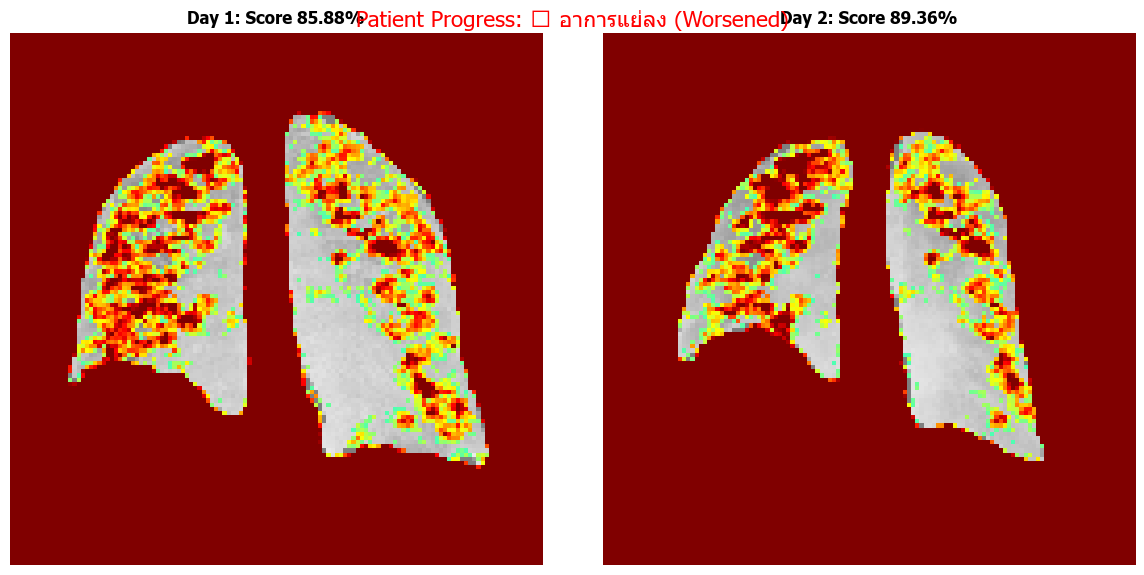

In [23]:
def analyze_lesion_score(img_path, model, scheduler, start_timestep=200, threshold=0.25, seed=42):
    """
    เวอร์ชันนิ่งสนิท: ล็อก Seed + ตัดพื้นหลัง + กรองกระดูก
    """
    # 1. เตรียมภาพ
    input_tensor, original_img_np = process_image(img_path)
    if input_tensor is None: return None, 0.0

    # --- 🔒 FIX: ล็อกค่าสุ่มตรงนี้ครับ (สำคัญมาก!) ---
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
    # ----------------------------------------------

    # 2. ใส่ Noise 
    noise = torch.randn(input_tensor.shape).to(device)
    timesteps = torch.tensor([start_timestep], device=device).long()
    noisy_image = scheduler.add_noise(input_tensor, noise, timesteps)

    # 3. ซ่อมภาพ
    current_image = noisy_image
    scheduler_timesteps = scheduler.timesteps
    start_index = (scheduler_timesteps == start_timestep).nonzero(as_tuple=True)[0].item()
    subset_timesteps = scheduler_timesteps[start_index:]

    for t in subset_timesteps:
        with torch.no_grad():
            model_output = model(current_image, t).sample
            current_image = scheduler.step(model_output, t, current_image).prev_sample

    # 4. คำนวณความต่าง
    img_recon = current_image.cpu().numpy()[0, 0]
    img_orig = input_tensor.cpu().numpy()[0, 0]
    
    # แปลงช่วงข้อมูลให้เป็น 0-1 เหมือนกัน
    img_orig = (img_orig + 1) / 2
    img_recon = (img_recon - img_recon.min()) / (img_recon.max() - img_recon.min())
    
    # Post-process
    img_orig_blur = cv2.GaussianBlur(img_orig, (3, 3), 0)
    diff_clean = np.abs(img_orig_blur - img_recon)
    
    # --- Clean Background & Ribs ---
    background_mask = np.where(img_orig < 0.1, 0, 1) 
    diff_clean = diff_clean * background_mask 
    
    lesion_map = np.where(diff_clean > threshold, diff_clean, 0)

    # 5. คำนวณคะแนน
    lesion_pixels = np.count_nonzero(lesion_map)
    lung_pixels = np.count_nonzero(img_orig > 0.1)
    
    if lung_pixels == 0: score = 0.0
    else: score = (lesion_pixels / lung_pixels) * 100

    # 6. สร้างภาพ Overlay
    heatmap_display = np.clip(lesion_map * 3, 0, 1)
    heatmap_color = cv2.applyColorMap((heatmap_display * 255).astype(np.uint8), cv2.COLORMAP_JET)
    
    orig_bgr = cv2.cvtColor((img_orig * 255).astype(np.uint8), cv2.COLOR_GRAY2BGR)
    
    mask_lesion = (heatmap_display > 0).astype(np.uint8) * 255
    bg = cv2.bitwise_and(orig_bgr, orig_bgr, mask=cv2.bitwise_not(mask_lesion))
    fg = cv2.bitwise_and(heatmap_color, heatmap_color, mask=mask_lesion)
    overlay = cv2.add(bg, fg)

    return overlay, score

# เรียกใช้งาน
print("🔄 Testing with Fixed Seed (ผลลัพธ์ต้องเหมือนเดิมทุกรอบ)...")
compare_progress(IMAGE_DAY_1, IMAGE_DAY_2, model, noise_scheduler)

🔄 กำลังเปรียบเทียบอาการ...

📊 ผลลัพธ์: ❌ อาการแย่ลง (Worsened) (+1.84%)
   - Day 1: 85.68%
   - Day 2: 87.52%


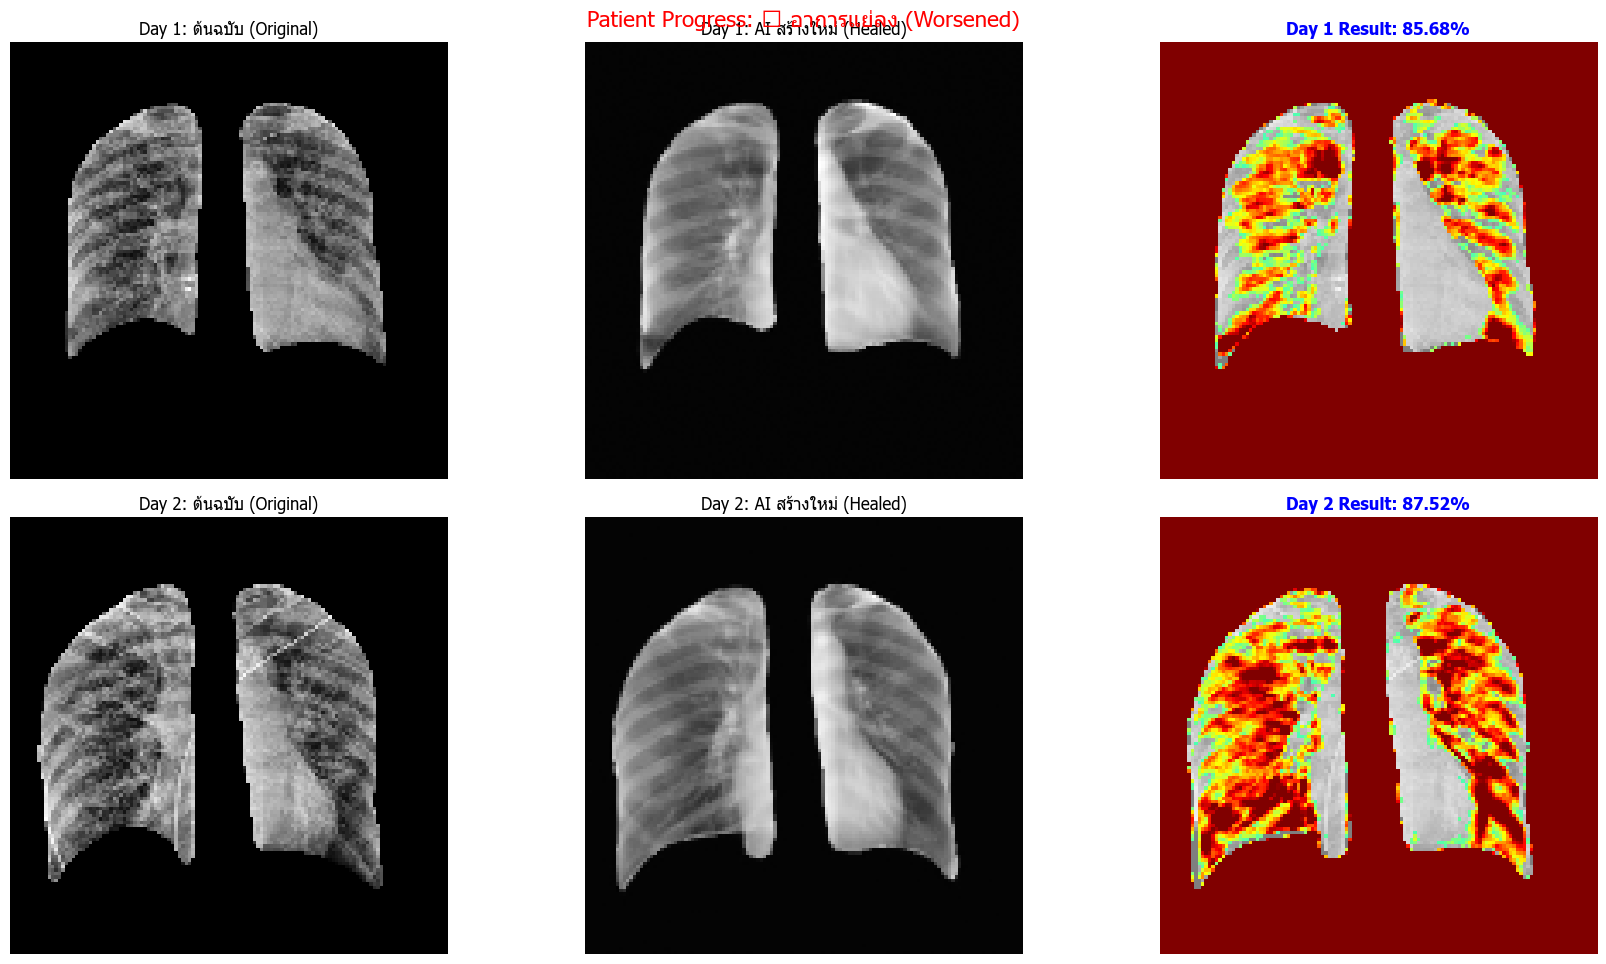

In [ ]:
def analyze_lesion_score(img_path, model, scheduler, start_timestep=180, threshold=0.15, seed=42):
    """
    คืนค่า 4 อย่าง: Overlay, Score, Original Image, AI Reconstructed Image
    """
    # 1. เตรียมภาพ
    input_tensor, original_img_np = process_image(img_path)
    if input_tensor is None: return None, 0.0, None, None

    # --- 🔒 ล็อกค่าสุ่ม (เพื่อความนิ่ง) ---
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

    # 2. ใส่ Noise 
    noise = torch.randn(input_tensor.shape).to(device)
    timesteps = torch.tensor([start_timestep], device=device).long()
    noisy_image = scheduler.add_noise(input_tensor, noise, timesteps)

    # 3. ซ่อมภาพ
    current_image = noisy_image
    scheduler_timesteps = scheduler.timesteps
    start_index = (scheduler_timesteps == start_timestep).nonzero(as_tuple=True)[0].item()
    subset_timesteps = scheduler_timesteps[start_index:]

    for t in subset_timesteps:
        with torch.no_grad():
            model_output = model(current_image, t).sample
            current_image = scheduler.step(model_output, t, current_image).prev_sample

    # 4. เตรียมข้อมูลภาพ
    img_recon = current_image.cpu().numpy()[0, 0]
    img_orig = input_tensor.cpu().numpy()[0, 0]
    
    # แปลงช่วงข้อมูลเป็น 0-1
    img_orig = (img_orig + 1) / 2
    img_recon = (img_recon - img_recon.min()) / (img_recon.max() - img_recon.min())
    
    # Post-process
    img_orig_blur = cv2.GaussianBlur(img_orig, (3, 3), 0)
    diff_clean = np.abs(img_orig_blur - img_recon)
    
    # Clean Background & Ribs
    background_mask = np.where(img_orig < 0.1, 0, 1) 
    diff_clean = diff_clean * background_mask 
    lesion_map = np.where(diff_clean > threshold, diff_clean, 0)

    # 5. คำนวณคะแนน
    lesion_pixels = np.count_nonzero(lesion_map)
    lung_pixels = np.count_nonzero(img_orig > 0.1)
    
    if lung_pixels == 0: score = 0.0
    else: score = (lesion_pixels / lung_pixels) * 100

    # 6. สร้างภาพ Overlay
    heatmap_display = np.clip(lesion_map * 3, 0, 1)
    heatmap_color = cv2.applyColorMap((heatmap_display * 255).astype(np.uint8), cv2.COLORMAP_JET)
    orig_bgr = cv2.cvtColor((img_orig * 255).astype(np.uint8), cv2.COLOR_GRAY2BGR)
    
    mask_lesion = (heatmap_display > 0).astype(np.uint8) * 255
    bg = cv2.bitwise_and(orig_bgr, orig_bgr, mask=cv2.bitwise_not(mask_lesion))
    fg = cv2.bitwise_and(heatmap_color, heatmap_color, mask=mask_lesion)
    overlay = cv2.add(bg, fg)

    # ⚡ คืนค่าภาพต้นฉบับและภาพ AI กลับไปด้วย
    return overlay, score, img_orig, img_recon

def compare_progress(path_day1, path_day2, model, scheduler):
    print(f"🔄 กำลังเปรียบเทียบอาการ...")
    
    # วิเคราะห์ Day 1
    overlay1, score1, orig1, recon1 = analyze_lesion_score(path_day1, model, scheduler)
    if overlay1 is None: print("❌ Error reading Day 1"); return

    # วิเคราะห์ Day 2
    overlay2, score2, orig2, recon2 = analyze_lesion_score(path_day2, model, scheduler)
    if overlay2 is None: print("❌ Error reading Day 2"); return

    # คำนวณผล
    diff_score = score2 - score1
    if diff_score < -1.0:
        status = "✅ อาการดีขึ้น (Improved)"
        color = 'green'
    elif diff_score > 1.0:
        status = "❌ อาการแย่ลง (Worsened)"
        color = 'red'
    else:
        status = "⚖️ อาการทรงตัว (Stable)"
        color = 'blue'

    print(f"\n📊 ผลลัพธ์: {status} ({diff_score:+.2f}%)")
    print(f"   - Day 1: {score1:.2f}%")
    print(f"   - Day 2: {score2:.2f}%")

    # ================= 🖼️ แสดงผลแบบตาราง 2x3 =================
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    
    # --- แถวที่ 1: Day 1 ---
    axes[0, 0].imshow(orig1, cmap='gray')
    axes[0, 0].set_title("Day 1: ต้นฉบับ (Original)", fontsize=12)
    
    axes[0, 1].imshow(recon1, cmap='gray')
    axes[0, 1].set_title("Day 1: AI สร้างใหม่ (Healed)", fontsize=12)
    
    axes[0, 2].imshow(cv2.cvtColor(overlay1, cv2.COLOR_BGR2RGB))
    axes[0, 2].set_title(f"Day 1 Result: {score1:.2f}%", fontsize=12, fontweight='bold', color='blue')
    
    # --- แถวที่ 2: Day 2 ---
    axes[1, 0].imshow(orig2, cmap='gray')
    axes[1, 0].set_title("Day 2: ต้นฉบับ (Original)", fontsize=12)
    
    axes[1, 1].imshow(recon2, cmap='gray')
    axes[1, 1].set_title("Day 2: AI สร้างใหม่ (Healed)", fontsize=12)
    
    axes[1, 2].imshow(cv2.cvtColor(overlay2, cv2.COLOR_BGR2RGB))
    axes[1, 2].set_title(f"Day 2 Result: {score2:.2f}%", fontsize=12, fontweight='bold', color='blue')
    
    # ปิดแกน x,y ให้สวยงาม
    for ax in axes.flat:
        ax.axis('off')

    plt.suptitle(f"Patient Progress: {status}", fontsize=16, color=color, y=0.96)
    plt.tight_layout()
    plt.show()

# เรียกใช้งาน
compare_progress(IMAGE_DAY_1, IMAGE_DAY_2, model, noise_scheduler)


🏥 กำลังตรวจสอบกลุ่ม: VAP

👤 ผู้ป่วย ID: 2131
   📅 เทียบ: 2131_cxr_vap_20250808_1.jpg vs 2131_cxr_vap_20250814_1.jpg
🔄 กำลังเปรียบเทียบอาการ...
📅 Day 1: 2131_cxr_vap_20250808_1.jpg
📅 Day 2: 2131_cxr_vap_20250814_1.jpg

📊 ผลลัพธ์:
   - คะแนน Day 1: 87.49%
   - คะแนน Day 2: 87.38%
   - สรุป: ⚖️ อาการทรงตัว (Stable) (-0.12%)


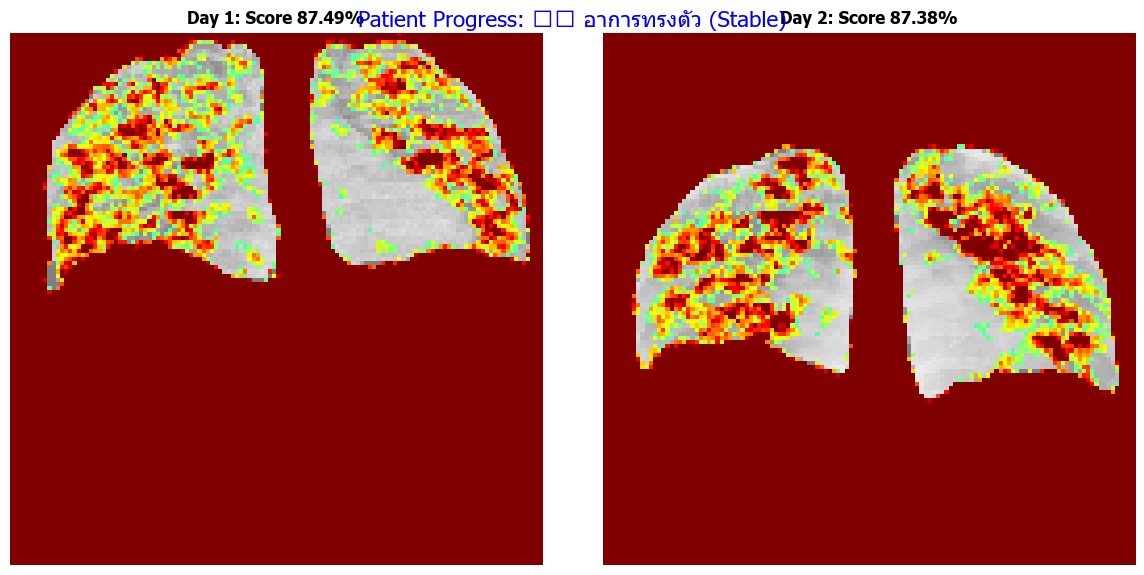


👤 ผู้ป่วย ID: 2140
   📅 เทียบ: 2140_cxr_vap_20250814_1.jpg vs 2140_cxr_vap_20250913_1.jpg
🔄 กำลังเปรียบเทียบอาการ...
📅 Day 1: 2140_cxr_vap_20250814_1.jpg
📅 Day 2: 2140_cxr_vap_20250913_1.jpg

📊 ผลลัพธ์:
   - คะแนน Day 1: 83.09%
   - คะแนน Day 2: 87.83%
   - สรุป: ❌ อาการแย่ลง (Worsened) (+4.74%)


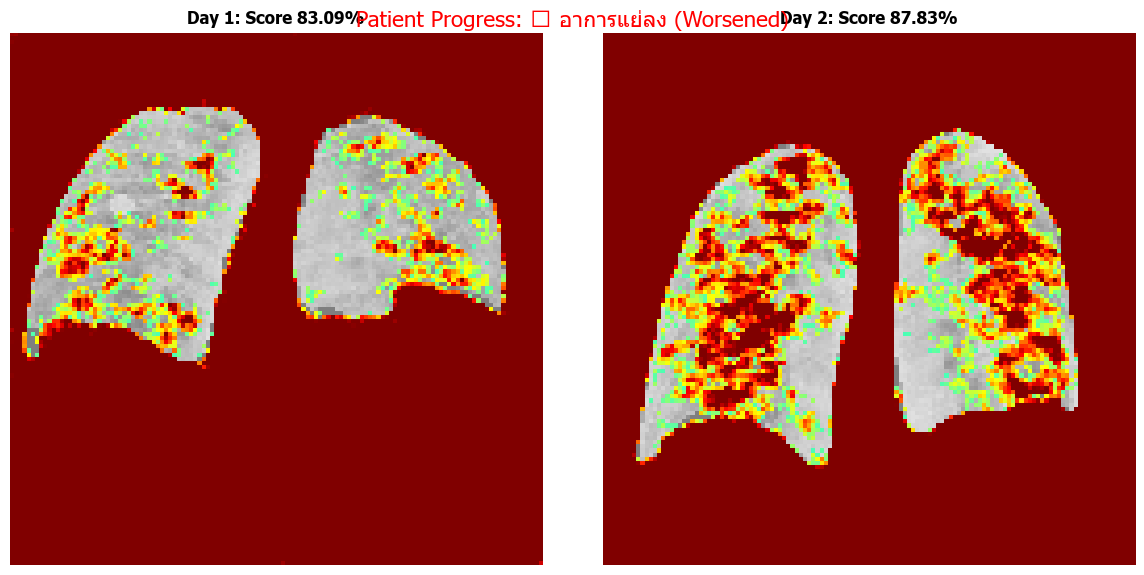


👤 ผู้ป่วย ID: 2157
   📅 เทียบ: 2157_cxr_vap_20250820_1.jpg vs 2157_cxr_vap_20250915_1.jpg
🔄 กำลังเปรียบเทียบอาการ...
📅 Day 1: 2157_cxr_vap_20250820_1.jpg
📅 Day 2: 2157_cxr_vap_20250915_1.jpg

📊 ผลลัพธ์:
   - คะแนน Day 1: 86.36%
   - คะแนน Day 2: 80.49%
   - สรุป: ✅ อาการดีขึ้น (Improved) (-5.87%)


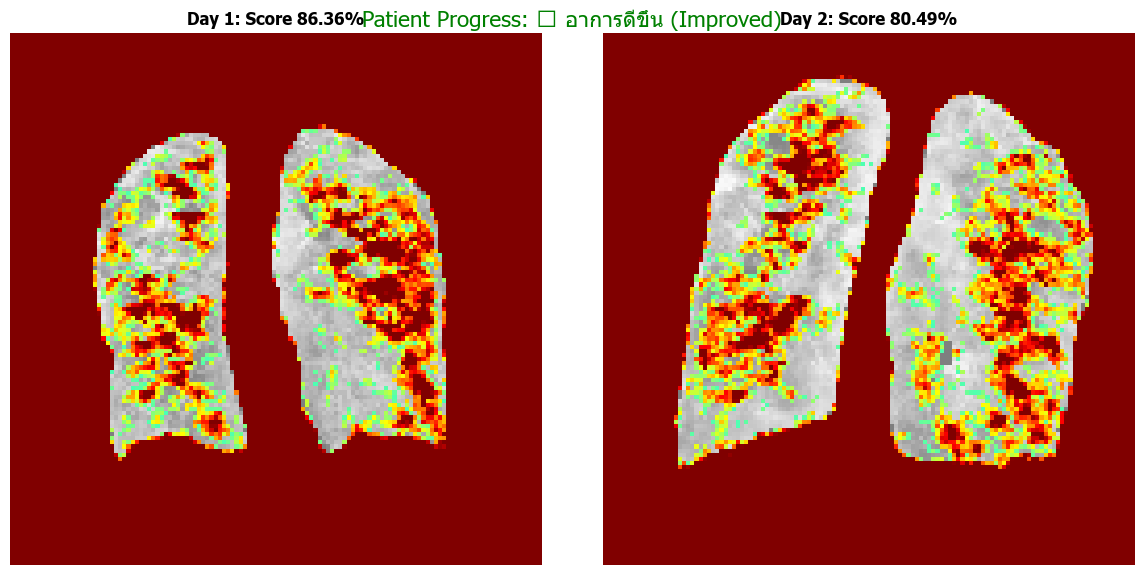


👤 ผู้ป่วย ID: 2167
   📅 เทียบ: 2167_cxr_vap_20250825_1.jpg vs 2167_cxr_vap_20250916_1.jpg
🔄 กำลังเปรียบเทียบอาการ...
📅 Day 1: 2167_cxr_vap_20250825_1.jpg
📅 Day 2: 2167_cxr_vap_20250916_1.jpg

📊 ผลลัพธ์:
   - คะแนน Day 1: 87.62%
   - คะแนน Day 2: 88.68%
   - สรุป: ❌ อาการแย่ลง (Worsened) (+1.06%)


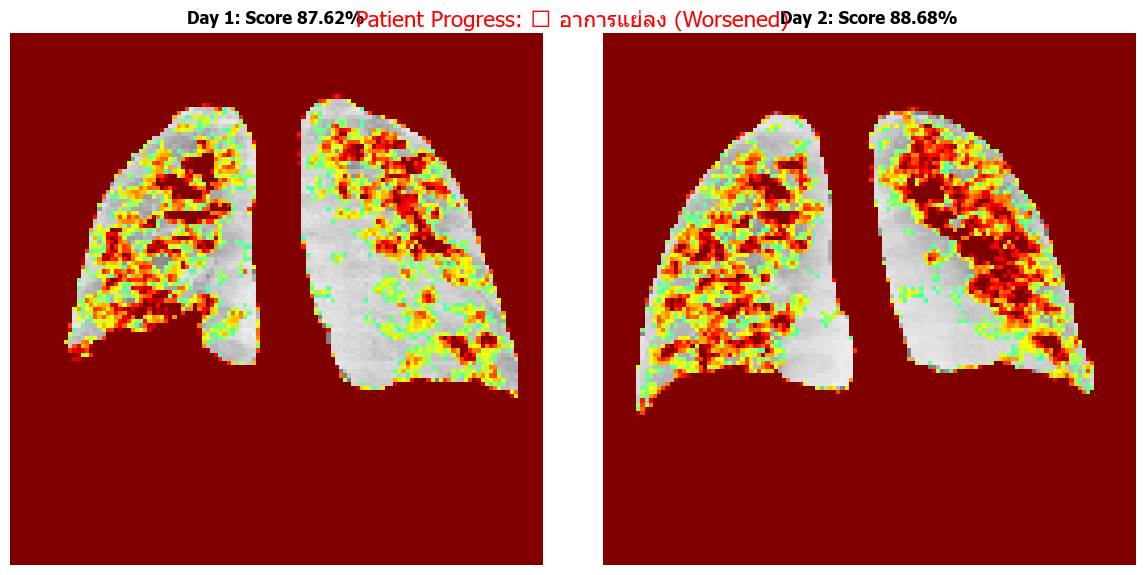


👤 ผู้ป่วย ID: 2179
   📅 เทียบ: 2179_cxr_vap_20250827_1.jpg vs 2179_cxr_vap_20251004_1.jpg
🔄 กำลังเปรียบเทียบอาการ...
📅 Day 1: 2179_cxr_vap_20250827_1.jpg
📅 Day 2: 2179_cxr_vap_20251004_1.jpg

📊 ผลลัพธ์:
   - คะแนน Day 1: 93.52%
   - คะแนน Day 2: 93.98%
   - สรุป: ⚖️ อาการทรงตัว (Stable) (+0.46%)


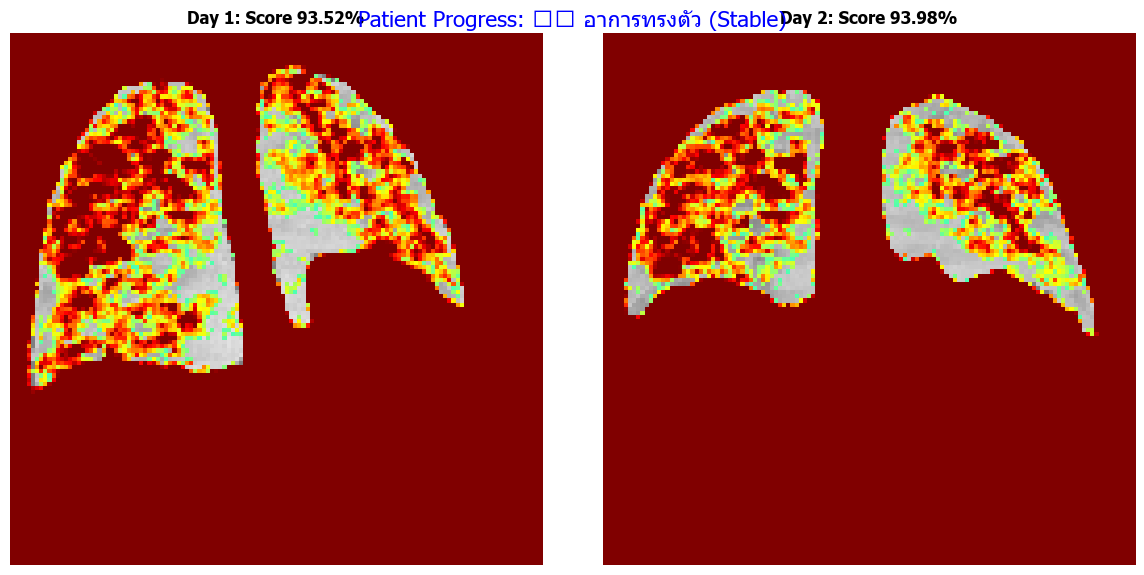


👤 ผู้ป่วย ID: 2199
   📅 เทียบ: 2199_cxr_vap_20250904_1.jpg vs 2199_cxr_vap_20250925_1.jpg
🔄 กำลังเปรียบเทียบอาการ...
📅 Day 1: 2199_cxr_vap_20250904_1.jpg
📅 Day 2: 2199_cxr_vap_20250925_1.jpg

📊 ผลลัพธ์:
   - คะแนน Day 1: 85.13%
   - คะแนน Day 2: 85.14%
   - สรุป: ⚖️ อาการทรงตัว (Stable) (+0.01%)


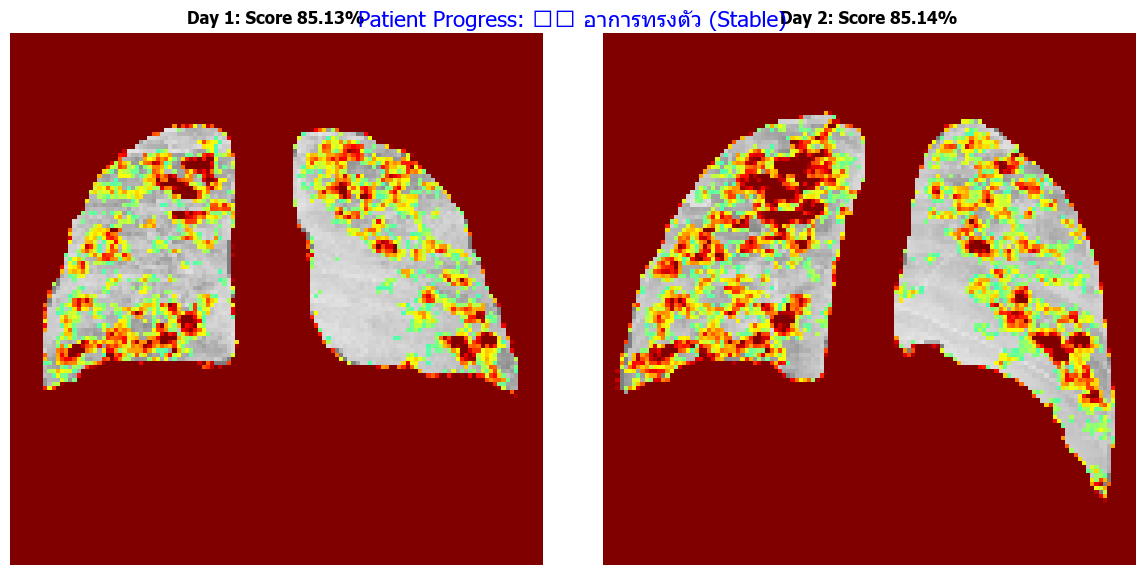


👤 ผู้ป่วย ID: 2200
   📅 เทียบ: 2200_cxr_vap_20250904_1.jpg vs 2200_cxr_vap_20250923_1.jpg
🔄 กำลังเปรียบเทียบอาการ...
📅 Day 1: 2200_cxr_vap_20250904_1.jpg
📅 Day 2: 2200_cxr_vap_20250923_1.jpg

📊 ผลลัพธ์:
   - คะแนน Day 1: 84.38%
   - คะแนน Day 2: 87.21%
   - สรุป: ❌ อาการแย่ลง (Worsened) (+2.83%)


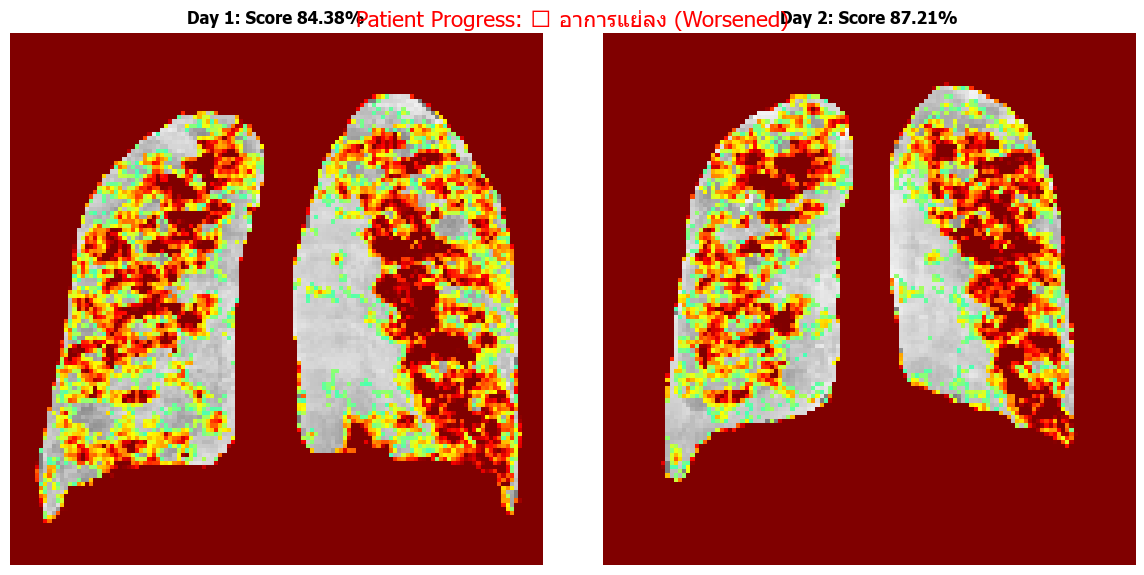


👤 ผู้ป่วย ID: 2203
   📅 เทียบ: 2203_cxr_vap_20250908_1.jpg vs 2203_cxr_vap_20250910_1.jpg
🔄 กำลังเปรียบเทียบอาการ...
📅 Day 1: 2203_cxr_vap_20250908_1.jpg
📅 Day 2: 2203_cxr_vap_20250910_1.jpg

📊 ผลลัพธ์:
   - คะแนน Day 1: 89.86%
   - คะแนน Day 2: 85.22%
   - สรุป: ✅ อาการดีขึ้น (Improved) (-4.64%)


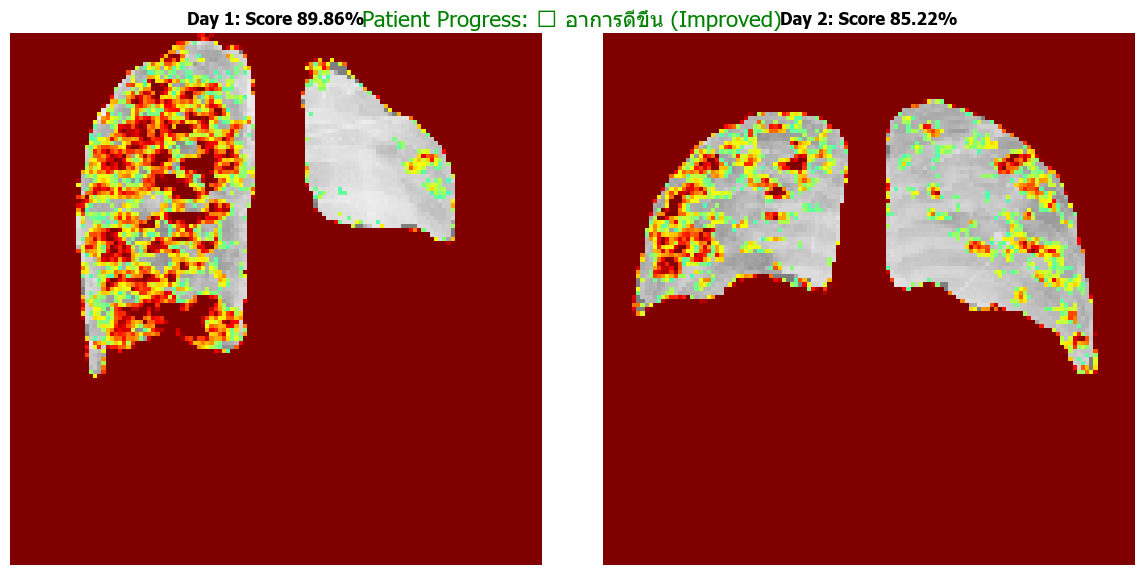


👤 ผู้ป่วย ID: 2214
   📅 เทียบ: 2214_cxr_vap_20250911_1.jpg vs 2214_cxr_vap_20250922_1.jpg
🔄 กำลังเปรียบเทียบอาการ...
📅 Day 1: 2214_cxr_vap_20250911_1.jpg
📅 Day 2: 2214_cxr_vap_20250922_1.jpg

📊 ผลลัพธ์:
   - คะแนน Day 1: 85.25%
   - คะแนน Day 2: 82.57%
   - สรุป: ✅ อาการดีขึ้น (Improved) (-2.67%)


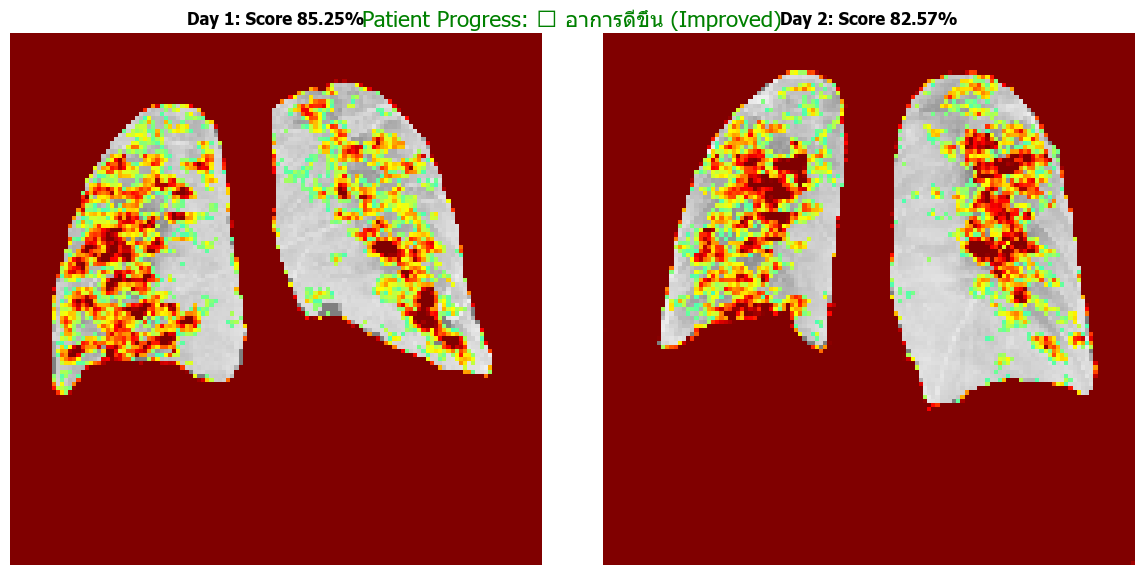


👤 ผู้ป่วย ID: 2219
   📅 เทียบ: 2219_cxr_vap_20250915_1.jpg vs 2219_cxr_vap_20250925_1.jpg
🔄 กำลังเปรียบเทียบอาการ...
📅 Day 1: 2219_cxr_vap_20250915_1.jpg
📅 Day 2: 2219_cxr_vap_20250925_1.jpg

📊 ผลลัพธ์:
   - คะแนน Day 1: 85.10%
   - คะแนน Day 2: 85.68%
   - สรุป: ⚖️ อาการทรงตัว (Stable) (+0.59%)


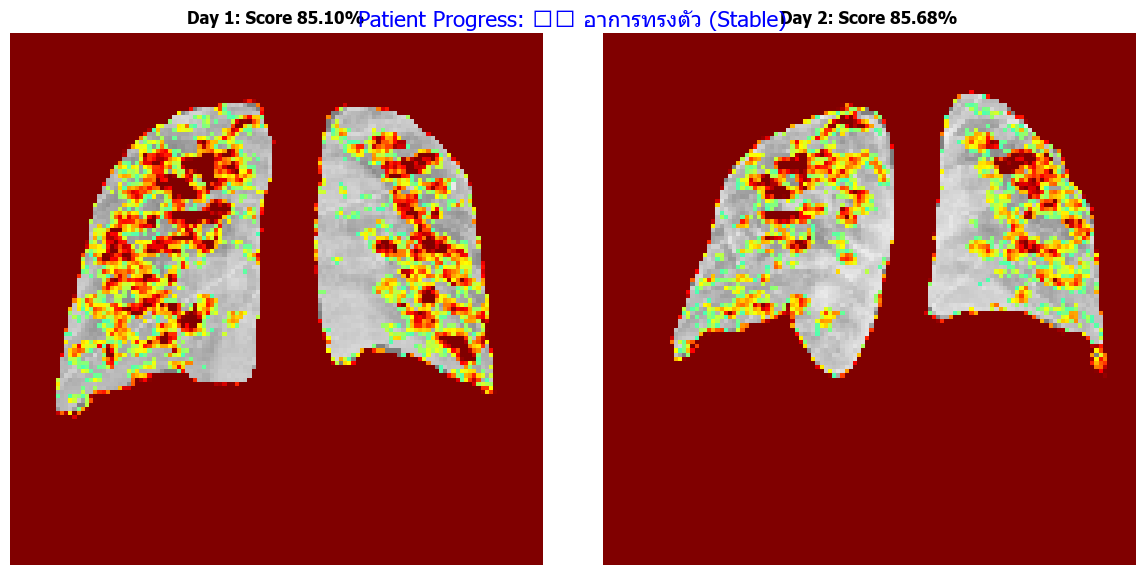


👤 ผู้ป่วย ID: 2226
   📅 เทียบ: 2226_cxr_vap_20250912_1.jpg vs 2226_cxr_vap_20251001_1.jpg
🔄 กำลังเปรียบเทียบอาการ...
📅 Day 1: 2226_cxr_vap_20250912_1.jpg
📅 Day 2: 2226_cxr_vap_20251001_1.jpg

📊 ผลลัพธ์:
   - คะแนน Day 1: 86.58%
   - คะแนน Day 2: 86.54%
   - สรุป: ⚖️ อาการทรงตัว (Stable) (-0.04%)


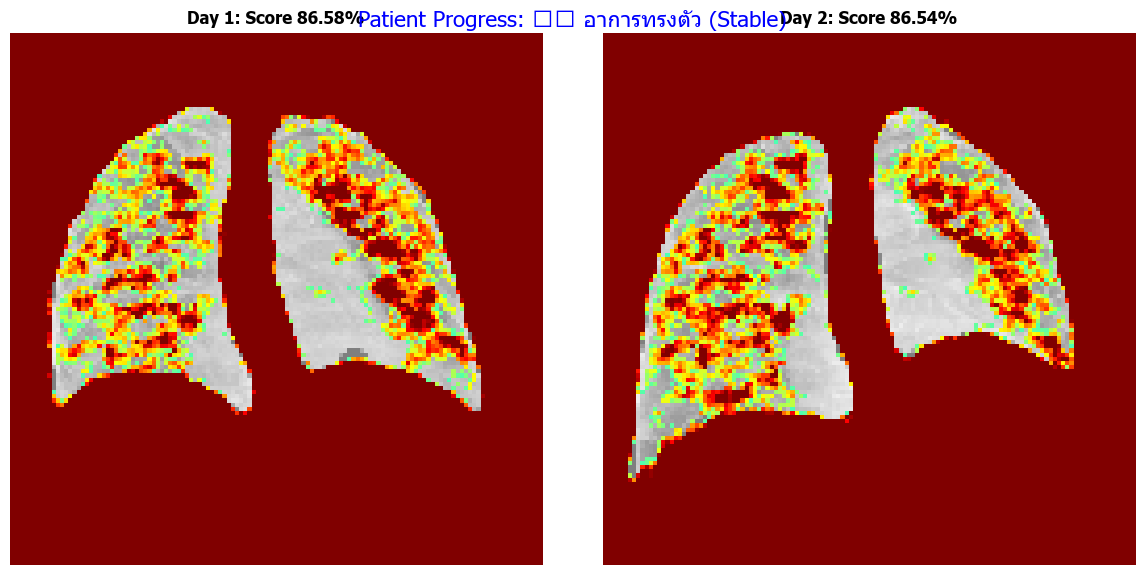


👤 ผู้ป่วย ID: 2230
   📅 เทียบ: 2230_cxr_vap_20250918_1.jpg vs 2230_cxr_vap_20251007_1.jpg
🔄 กำลังเปรียบเทียบอาการ...
📅 Day 1: 2230_cxr_vap_20250918_1.jpg
📅 Day 2: 2230_cxr_vap_20251007_1.jpg

📊 ผลลัพธ์:
   - คะแนน Day 1: 89.86%
   - คะแนน Day 2: 89.96%
   - สรุป: ⚖️ อาการทรงตัว (Stable) (+0.10%)


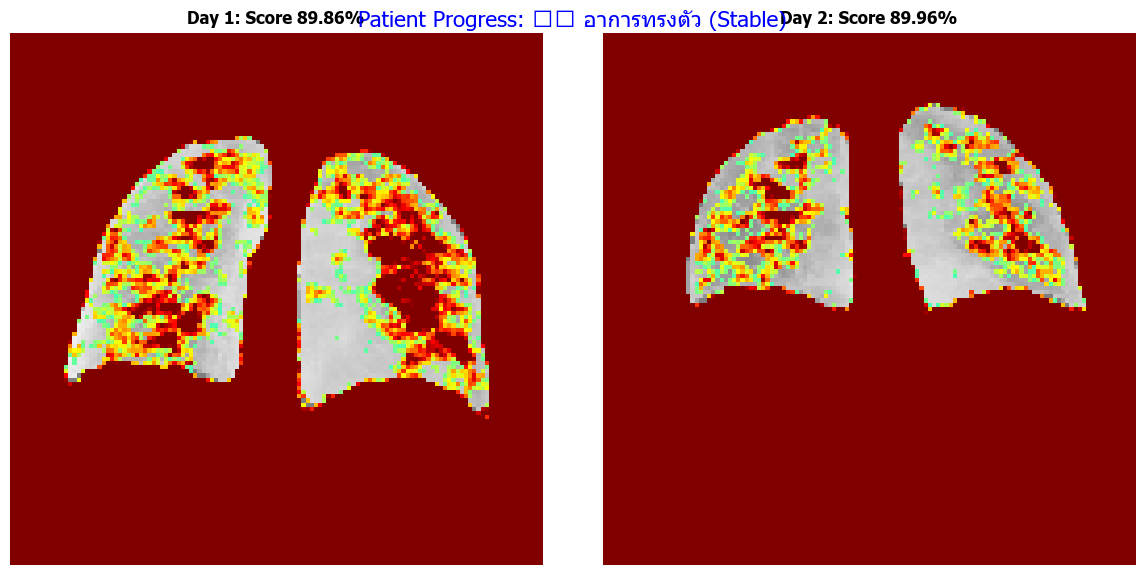


👤 ผู้ป่วย ID: 2231
   📅 เทียบ: 2231_cxr_vap_20250918_1.jpg vs 2231_cxr_vap_20251001_1.jpg
🔄 กำลังเปรียบเทียบอาการ...
📅 Day 1: 2231_cxr_vap_20250918_1.jpg
📅 Day 2: 2231_cxr_vap_20251001_1.jpg

📊 ผลลัพธ์:
   - คะแนน Day 1: 87.28%
   - คะแนน Day 2: 89.54%
   - สรุป: ❌ อาการแย่ลง (Worsened) (+2.26%)


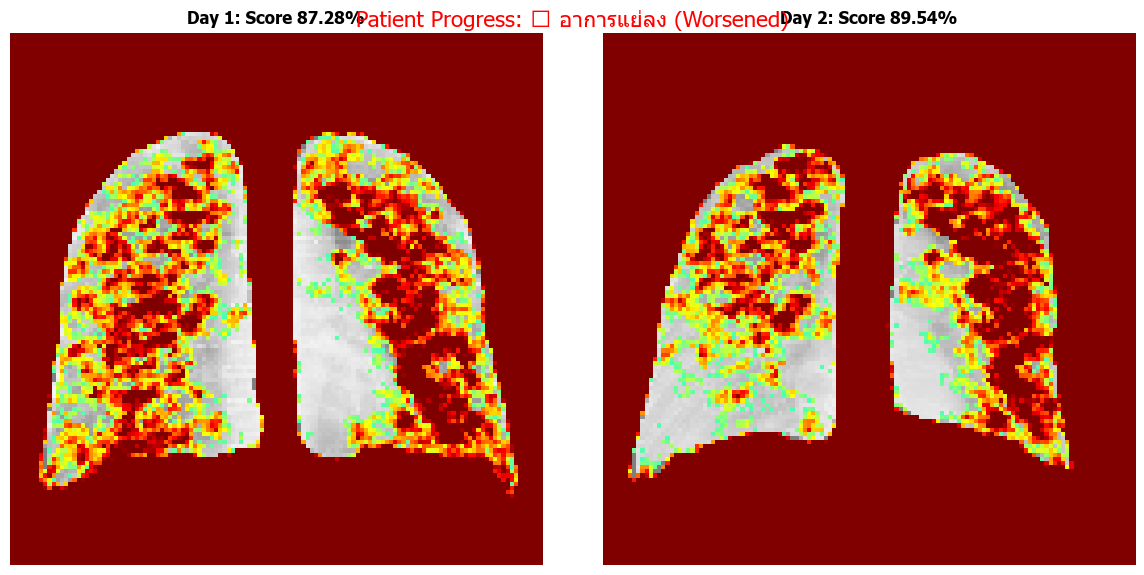


👤 ผู้ป่วย ID: 2241
   📅 เทียบ: 2241_cxr_vap_20250923_1.jpg vs 2241_cxr_vap_20250929_1.jpg
🔄 กำลังเปรียบเทียบอาการ...
📅 Day 1: 2241_cxr_vap_20250923_1.jpg
📅 Day 2: 2241_cxr_vap_20250929_1.jpg

📊 ผลลัพธ์:
   - คะแนน Day 1: 85.17%
   - คะแนน Day 2: 92.35%
   - สรุป: ❌ อาการแย่ลง (Worsened) (+7.18%)


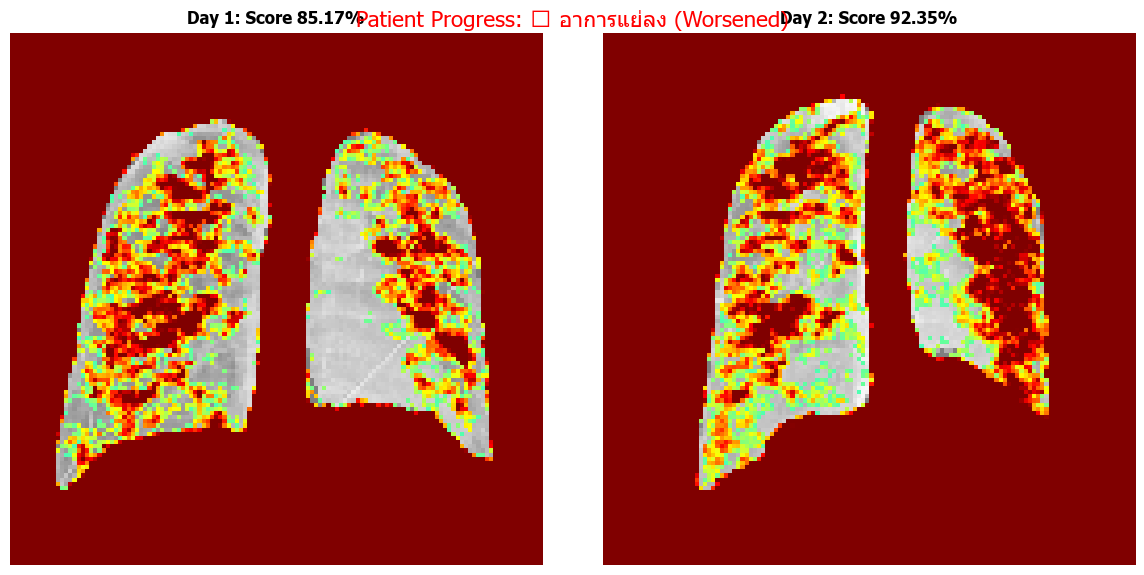


👤 ผู้ป่วย ID: 2266
   📅 เทียบ: 2266_cxr_vap_20250930_1.jpg vs 2266_cxr_vap_20251005_1.jpg
🔄 กำลังเปรียบเทียบอาการ...
📅 Day 1: 2266_cxr_vap_20250930_1.jpg
📅 Day 2: 2266_cxr_vap_20251005_1.jpg

📊 ผลลัพธ์:
   - คะแนน Day 1: 85.24%
   - คะแนน Day 2: 84.75%
   - สรุป: ⚖️ อาการทรงตัว (Stable) (-0.48%)


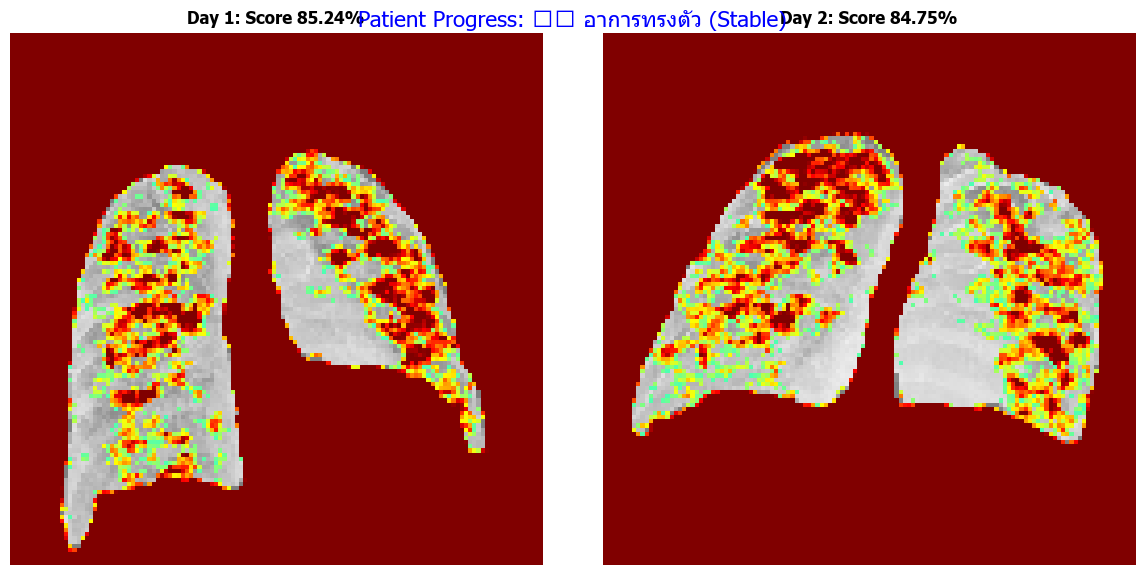


👤 ผู้ป่วย ID: 2277
   📅 เทียบ: 2277_cxr_vap_20251002_1.jpg vs 2277_cxr_vap_20251016_1.jpg
🔄 กำลังเปรียบเทียบอาการ...
📅 Day 1: 2277_cxr_vap_20251002_1.jpg
📅 Day 2: 2277_cxr_vap_20251016_1.jpg

📊 ผลลัพธ์:
   - คะแนน Day 1: 88.70%
   - คะแนน Day 2: 91.32%
   - สรุป: ❌ อาการแย่ลง (Worsened) (+2.62%)


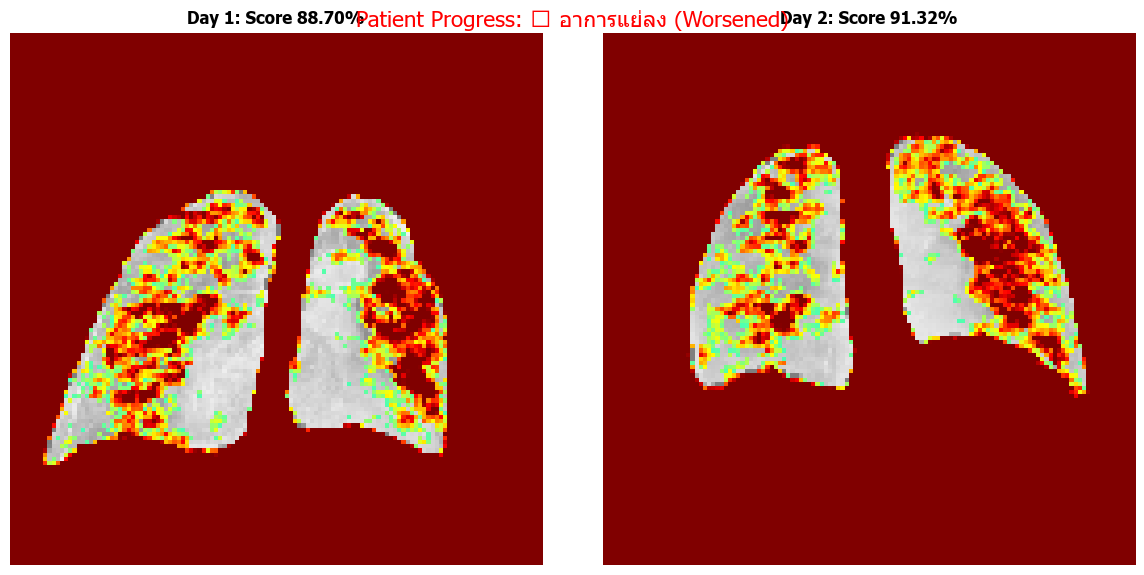


👤 ผู้ป่วย ID: 2287
   📅 เทียบ: 2287_cxr_vap_20251005_1.jpg vs 2287_cxr_vap_20251007_1.jpg
🔄 กำลังเปรียบเทียบอาการ...
📅 Day 1: 2287_cxr_vap_20251005_1.jpg
📅 Day 2: 2287_cxr_vap_20251007_1.jpg

📊 ผลลัพธ์:
   - คะแนน Day 1: 84.75%
   - คะแนน Day 2: 84.42%
   - สรุป: ⚖️ อาการทรงตัว (Stable) (-0.33%)


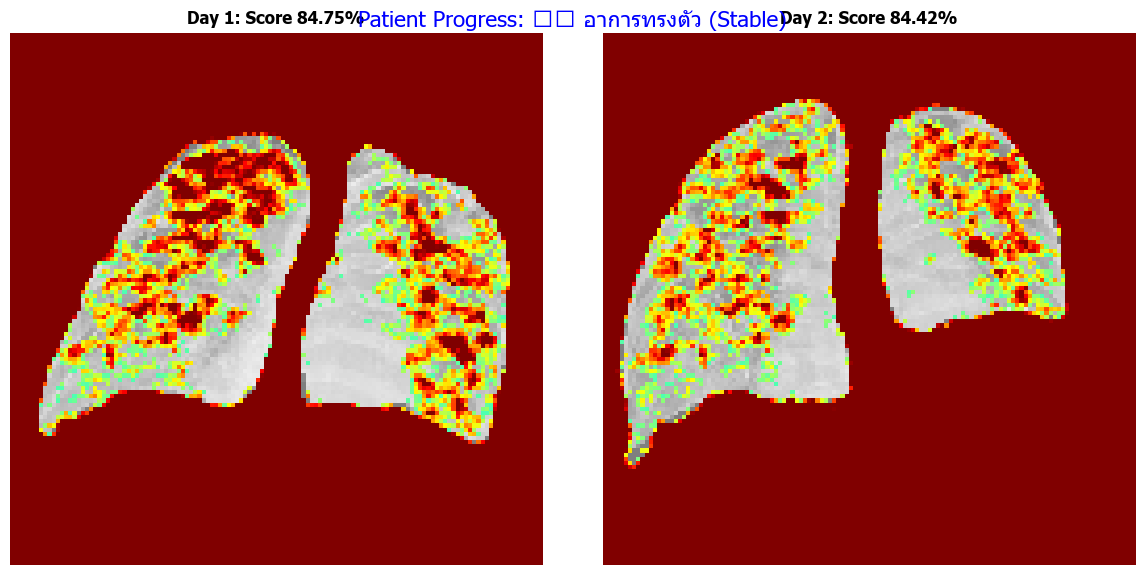


👤 ผู้ป่วย ID: 2291
   📅 เทียบ: 2291_cxr_vap_20251007_1.jpg vs 2291_cxr_vap_20251021_1.jpg
🔄 กำลังเปรียบเทียบอาการ...
📅 Day 1: 2291_cxr_vap_20251007_1.jpg
📅 Day 2: 2291_cxr_vap_20251021_1.jpg

📊 ผลลัพธ์:
   - คะแนน Day 1: 88.84%
   - คะแนน Day 2: 82.24%
   - สรุป: ✅ อาการดีขึ้น (Improved) (-6.60%)


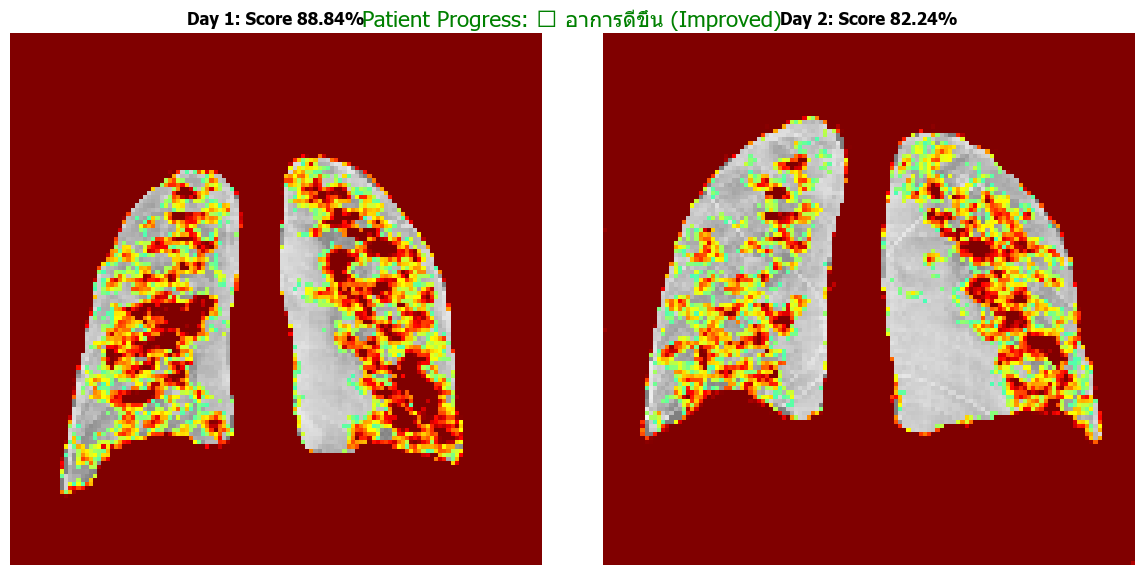


👤 ผู้ป่วย ID: 2292
   📅 เทียบ: 2292_cxr_vap_20251007_1.jpg vs 2292_cxr_vap_20251009_1.jpg
🔄 กำลังเปรียบเทียบอาการ...
📅 Day 1: 2292_cxr_vap_20251007_1.jpg
📅 Day 2: 2292_cxr_vap_20251009_1.jpg

📊 ผลลัพธ์:
   - คะแนน Day 1: 87.57%
   - คะแนน Day 2: 84.53%
   - สรุป: ✅ อาการดีขึ้น (Improved) (-3.04%)


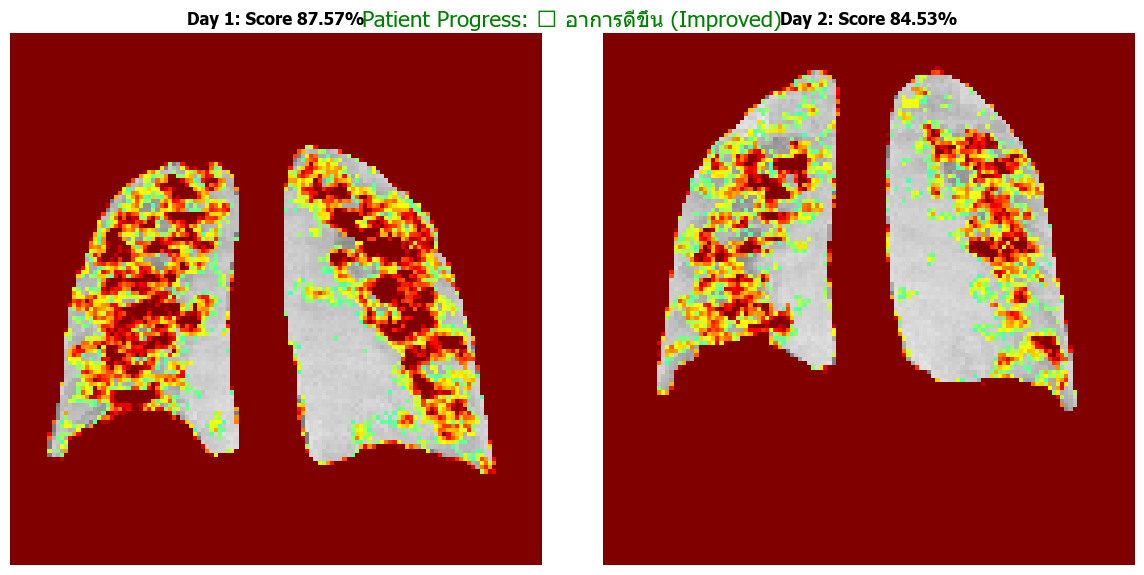


👤 ผู้ป่วย ID: 2306
   📅 เทียบ: 2306_cxr_vap_20251014_1.jpg vs 2306_cxr_vap_20251118_1.jpg
🔄 กำลังเปรียบเทียบอาการ...
📅 Day 1: 2306_cxr_vap_20251014_1.jpg
📅 Day 2: 2306_cxr_vap_20251118_1.jpg

📊 ผลลัพธ์:
   - คะแนน Day 1: 90.48%
   - คะแนน Day 2: 89.61%
   - สรุป: ⚖️ อาการทรงตัว (Stable) (-0.87%)


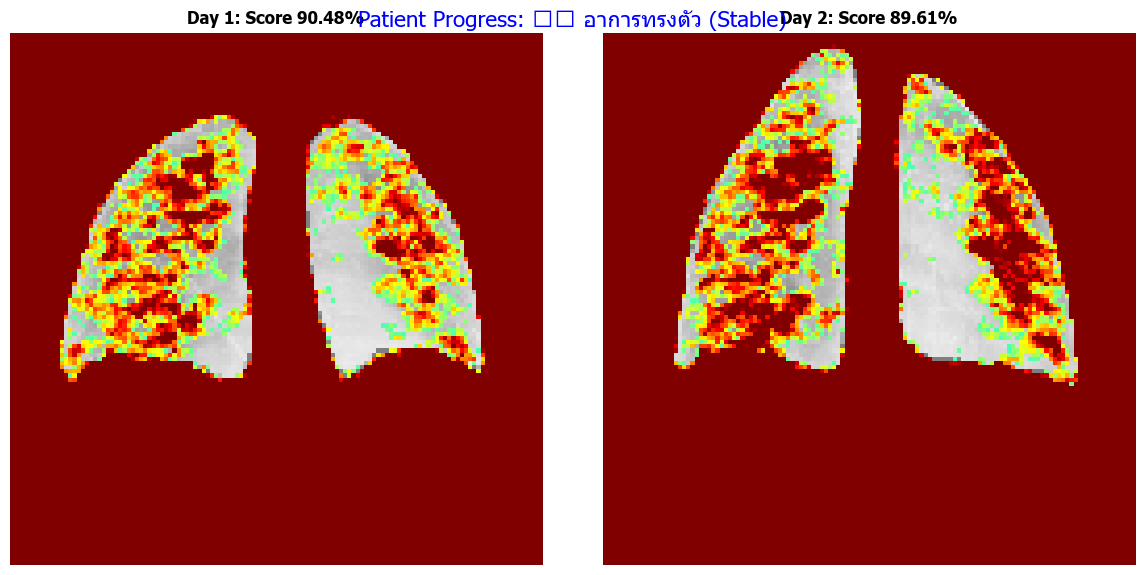


👤 ผู้ป่วย ID: 2319
   📅 เทียบ: 2319_cxr_vap_20251019_1.jpg vs 2319_cxr_vap_20251029_1.jpg
🔄 กำลังเปรียบเทียบอาการ...
📅 Day 1: 2319_cxr_vap_20251019_1.jpg
📅 Day 2: 2319_cxr_vap_20251029_1.jpg

📊 ผลลัพธ์:
   - คะแนน Day 1: 86.56%
   - คะแนน Day 2: 84.22%
   - สรุป: ✅ อาการดีขึ้น (Improved) (-2.34%)


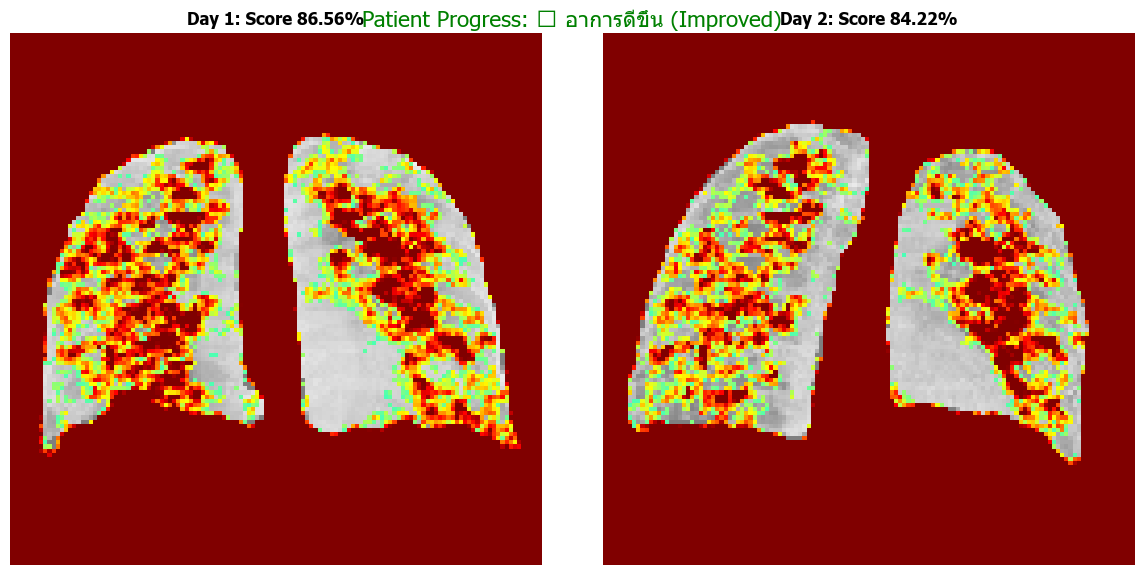


👤 ผู้ป่วย ID: 2332
   📅 เทียบ: 2332_cxr_vap_20251022_1.jpg vs 2332_cxr_vap_20251115_1.jpg
🔄 กำลังเปรียบเทียบอาการ...
📅 Day 1: 2332_cxr_vap_20251022_1.jpg
📅 Day 2: 2332_cxr_vap_20251115_1.jpg

📊 ผลลัพธ์:
   - คะแนน Day 1: 88.81%
   - คะแนน Day 2: 90.74%
   - สรุป: ❌ อาการแย่ลง (Worsened) (+1.93%)


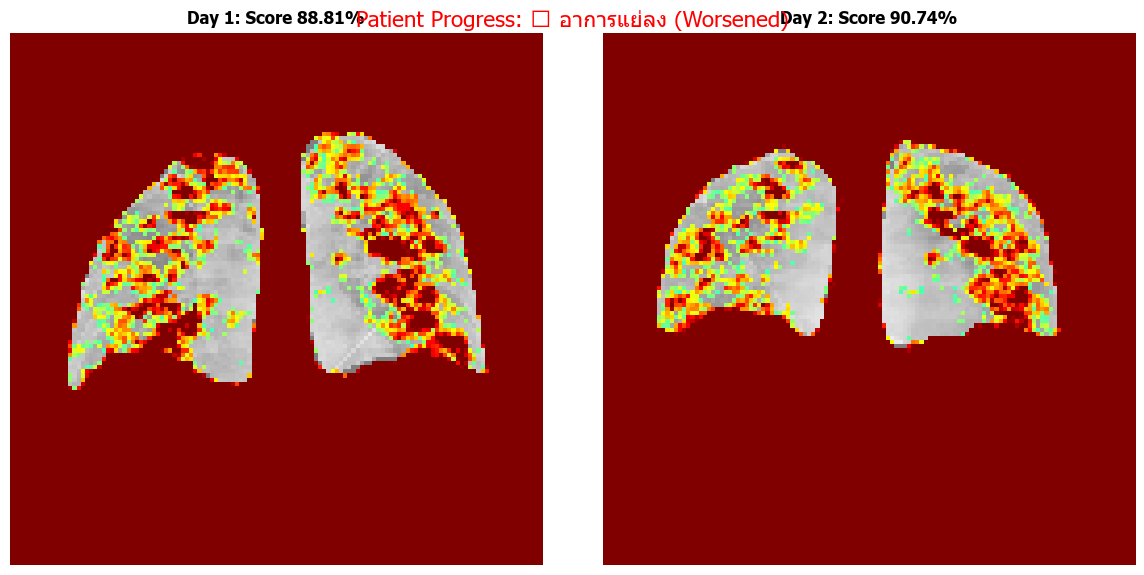


👤 ผู้ป่วย ID: 2345
   📅 เทียบ: 2345_cxr_vap_20251026_1.jpg vs 2345_cxr_vap_20251110_1.jpg
🔄 กำลังเปรียบเทียบอาการ...
📅 Day 1: 2345_cxr_vap_20251026_1.jpg
📅 Day 2: 2345_cxr_vap_20251110_1.jpg

📊 ผลลัพธ์:
   - คะแนน Day 1: 87.00%
   - คะแนน Day 2: 88.56%
   - สรุป: ❌ อาการแย่ลง (Worsened) (+1.56%)


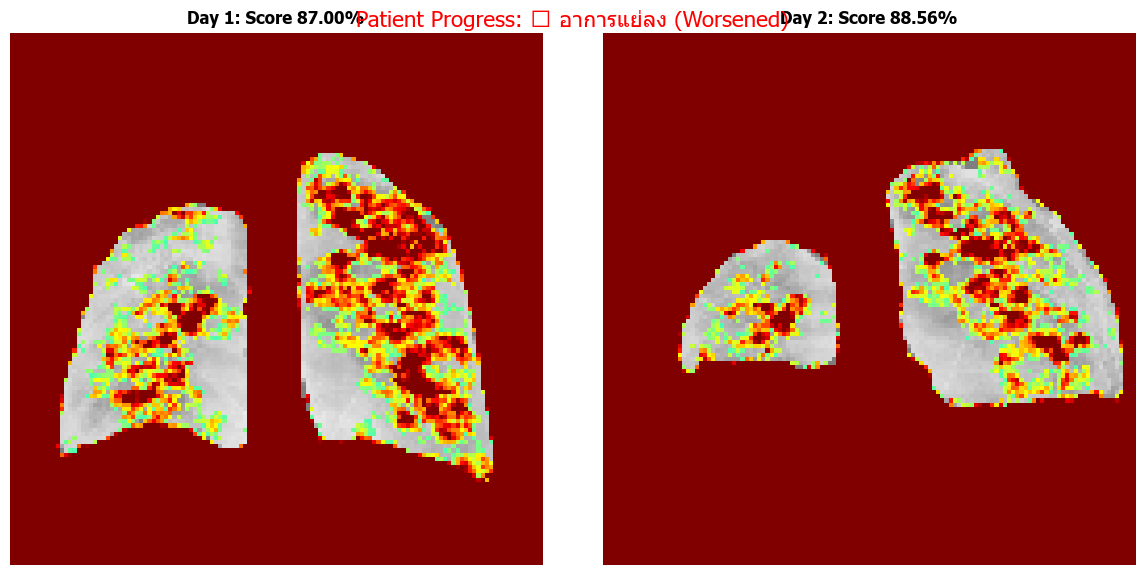


👤 ผู้ป่วย ID: 2359
   📅 เทียบ: 2359_cxr_vap_20251031_1.jpg vs 2359_cxr_vap_20251111_1.jpg
🔄 กำลังเปรียบเทียบอาการ...
📅 Day 1: 2359_cxr_vap_20251031_1.jpg
📅 Day 2: 2359_cxr_vap_20251111_1.jpg

📊 ผลลัพธ์:
   - คะแนน Day 1: 81.51%
   - คะแนน Day 2: 86.98%
   - สรุป: ❌ อาการแย่ลง (Worsened) (+5.46%)


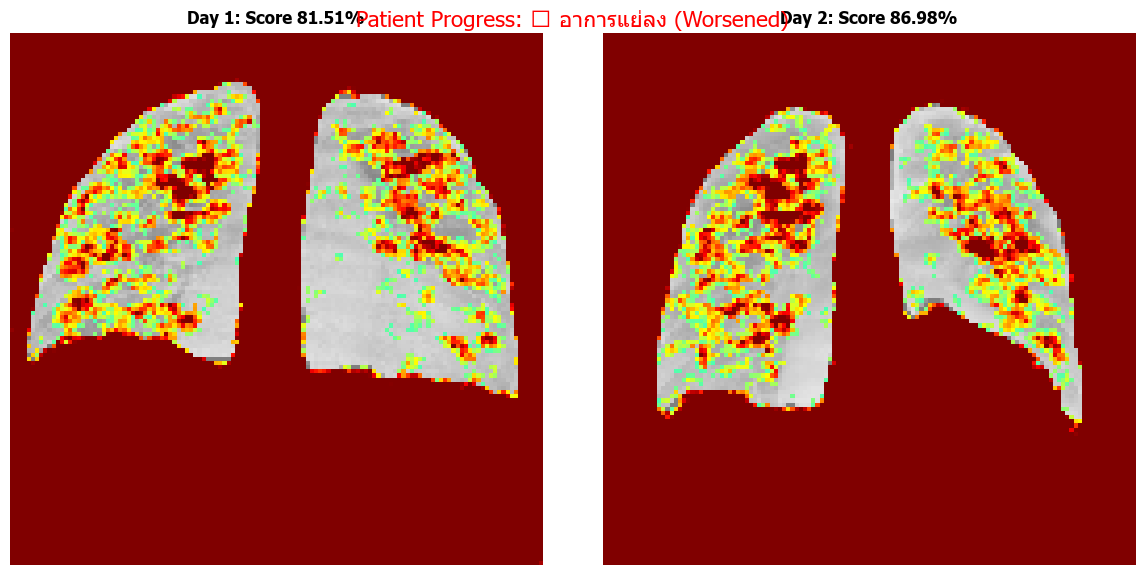


👤 ผู้ป่วย ID: 2380
   📅 เทียบ: 2380_cxr_vap_20251108_1.jpg vs 2380_cxr_vap_20251122_1.jpg
🔄 กำลังเปรียบเทียบอาการ...
📅 Day 1: 2380_cxr_vap_20251108_1.jpg
📅 Day 2: 2380_cxr_vap_20251122_1.jpg

📊 ผลลัพธ์:
   - คะแนน Day 1: 84.99%
   - คะแนน Day 2: 90.84%
   - สรุป: ❌ อาการแย่ลง (Worsened) (+5.85%)


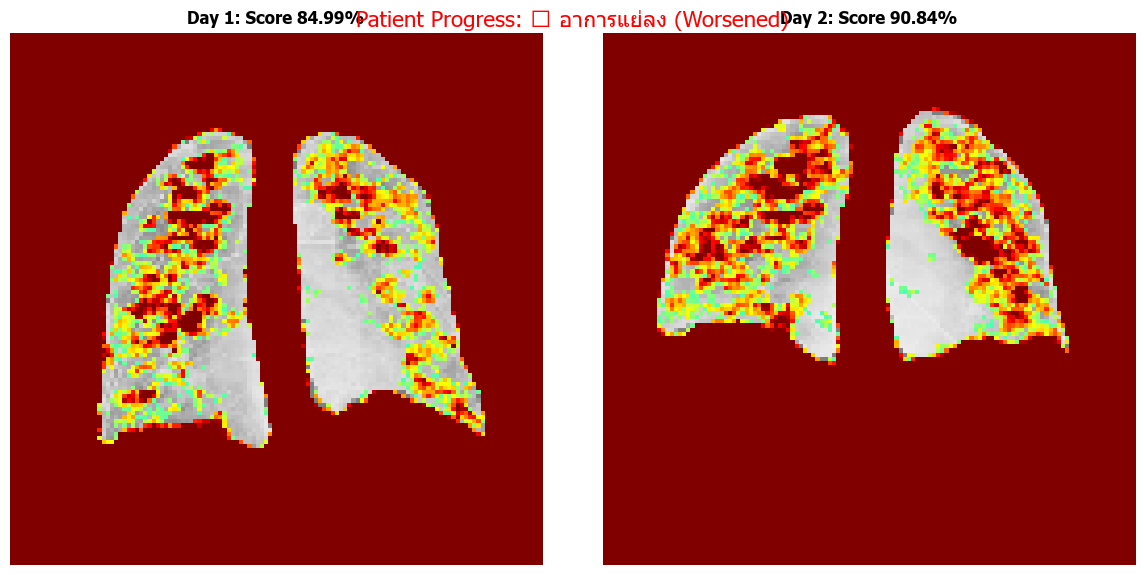


👤 ผู้ป่วย ID: 2404
   📅 เทียบ: 2404_cxr_vap_20251113_1.jpg vs 2404_cxr_vap_20251119_1.jpg
🔄 กำลังเปรียบเทียบอาการ...
📅 Day 1: 2404_cxr_vap_20251113_1.jpg
📅 Day 2: 2404_cxr_vap_20251119_1.jpg

📊 ผลลัพธ์:
   - คะแนน Day 1: 82.32%
   - คะแนน Day 2: 83.35%
   - สรุป: ❌ อาการแย่ลง (Worsened) (+1.03%)


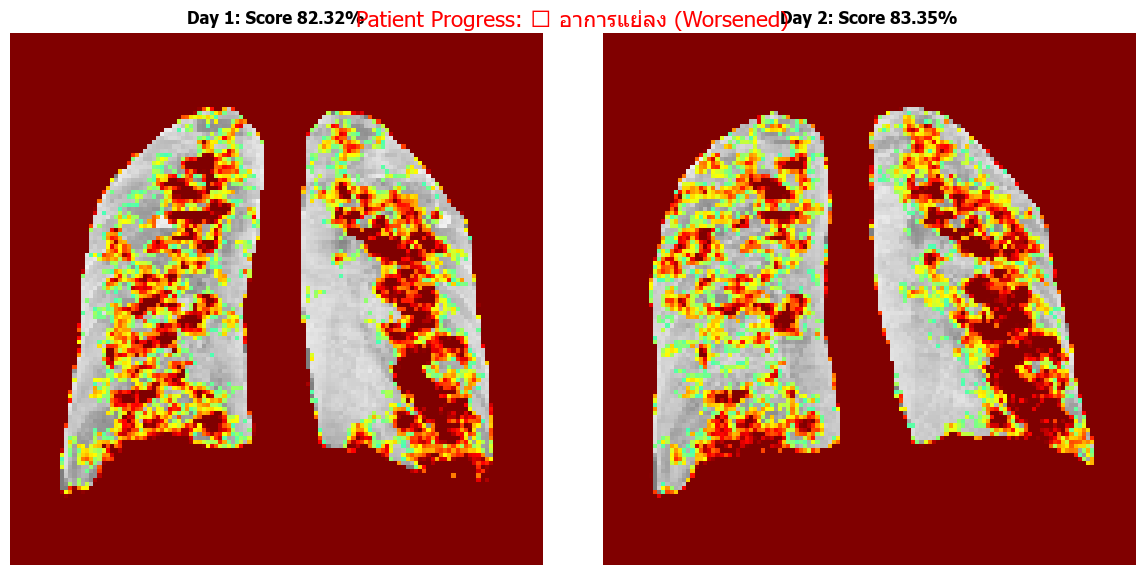


🏥 กำลังตรวจสอบกลุ่ม: NOVAP

👤 ผู้ป่วย ID: 2268
   📅 เทียบ: 2268_cxr_novap_20251001_1.jpg vs 2268_cxr_novap_20251010_1.jpg
🔄 กำลังเปรียบเทียบอาการ...
📅 Day 1: 2268_cxr_novap_20251001_1.jpg
📅 Day 2: 2268_cxr_novap_20251010_1.jpg

📊 ผลลัพธ์:
   - คะแนน Day 1: 85.88%
   - คะแนน Day 2: 91.14%
   - สรุป: ❌ อาการแย่ลง (Worsened) (+5.27%)


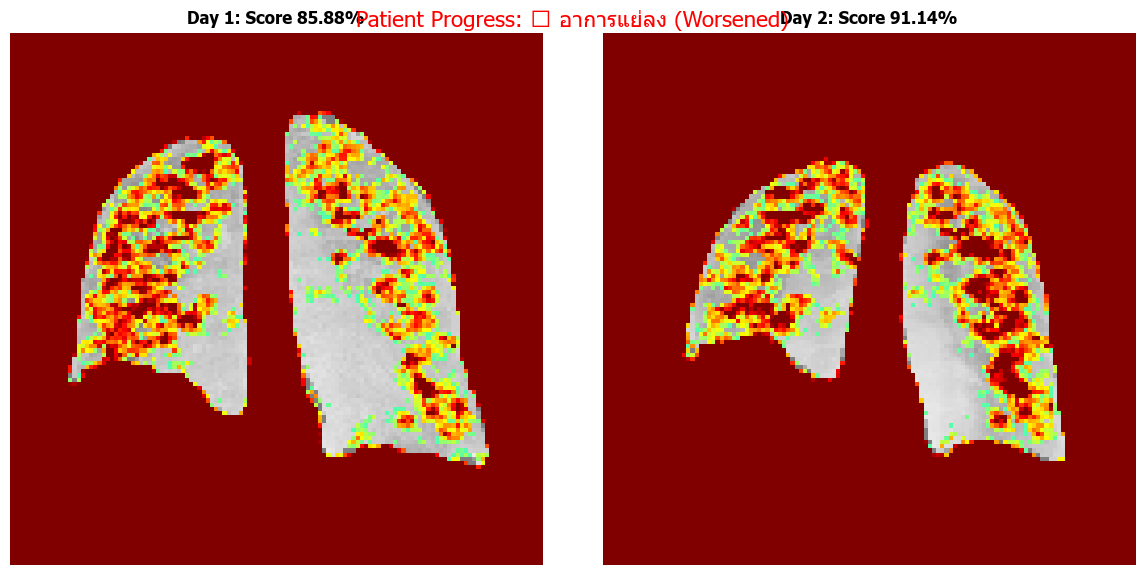


👤 ผู้ป่วย ID: 2272
   📅 เทียบ: 2272_cxr_novap_20251001_1.jpg vs 2272_cxr_novap_20251025_1.jpg
🔄 กำลังเปรียบเทียบอาการ...
📅 Day 1: 2272_cxr_novap_20251001_1.jpg
📅 Day 2: 2272_cxr_novap_20251025_1.jpg

📊 ผลลัพธ์:
   - คะแนน Day 1: 85.30%
   - คะแนน Day 2: 89.83%
   - สรุป: ❌ อาการแย่ลง (Worsened) (+4.53%)


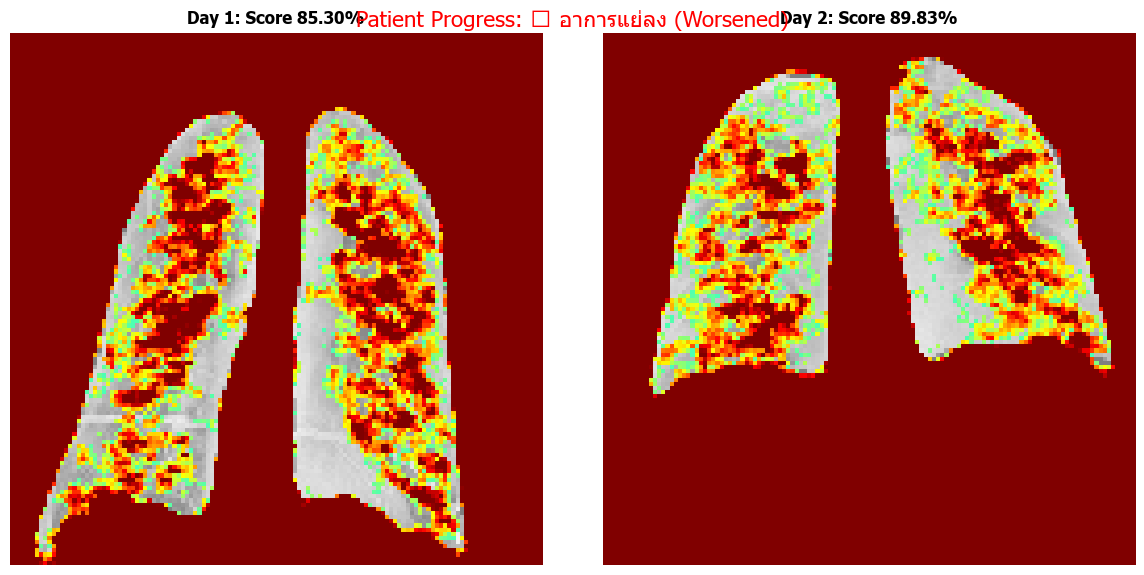


👤 ผู้ป่วย ID: 2273
   📅 เทียบ: 2273_cxr_novap_20251002_1.jpg vs 2273_cxr_novap_20251007_2.jpg
🔄 กำลังเปรียบเทียบอาการ...
📅 Day 1: 2273_cxr_novap_20251002_1.jpg
📅 Day 2: 2273_cxr_novap_20251007_2.jpg

📊 ผลลัพธ์:
   - คะแนน Day 1: 88.87%
   - คะแนน Day 2: 85.19%
   - สรุป: ✅ อาการดีขึ้น (Improved) (-3.68%)


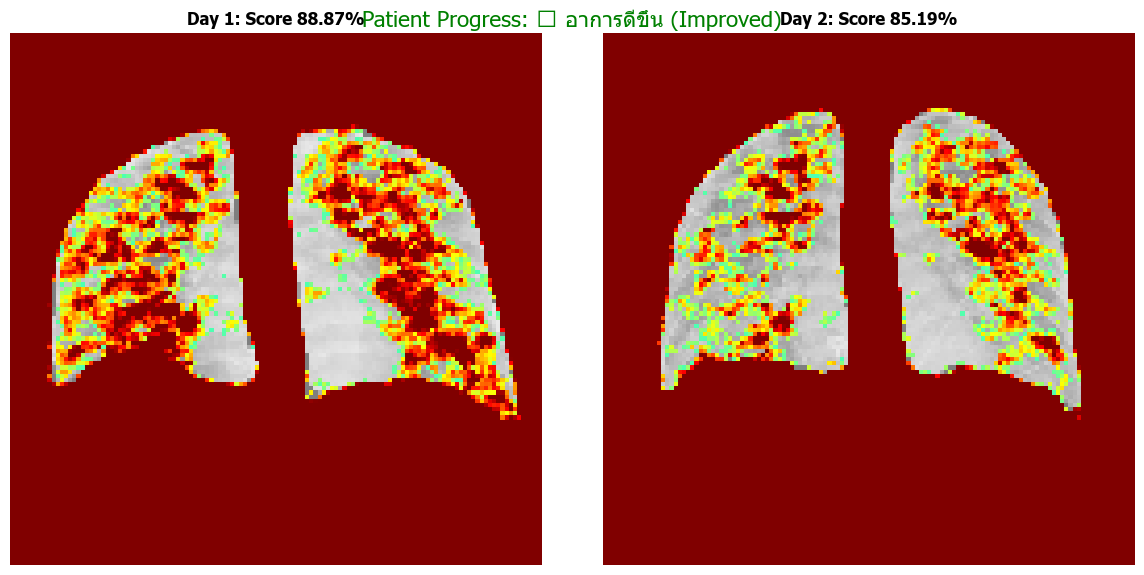


👤 ผู้ป่วย ID: 2278
   📅 เทียบ: 2278_cxr_novap_20251003_1.jpg vs 2278_cxr_novap_20251009_1.jpg
🔄 กำลังเปรียบเทียบอาการ...
📅 Day 1: 2278_cxr_novap_20251003_1.jpg
📅 Day 2: 2278_cxr_novap_20251009_1.jpg

📊 ผลลัพธ์:
   - คะแนน Day 1: 86.68%
   - คะแนน Day 2: 86.51%
   - สรุป: ⚖️ อาการทรงตัว (Stable) (-0.17%)


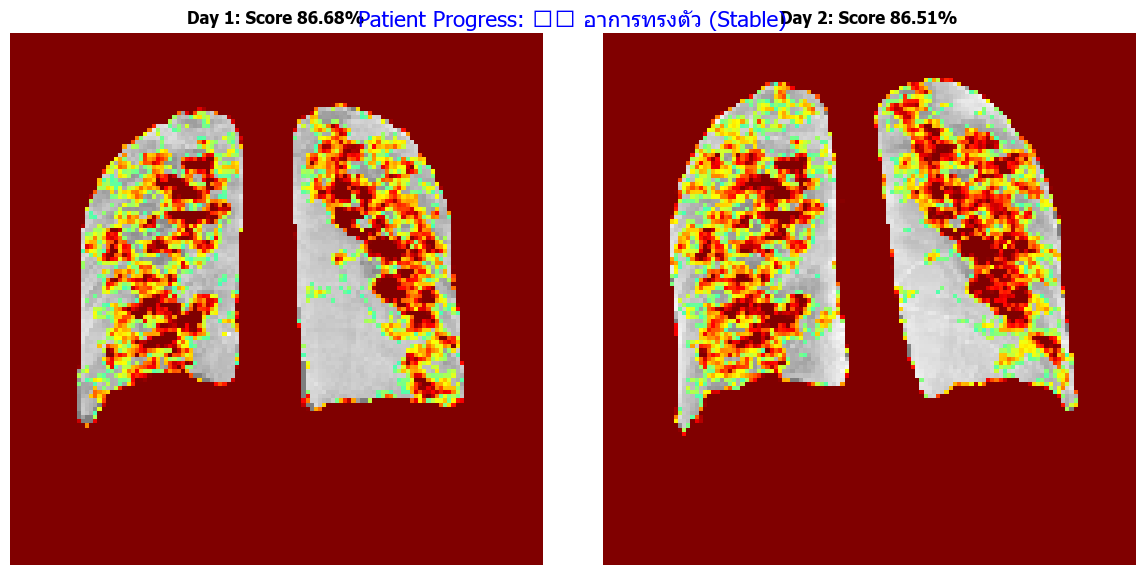


👤 ผู้ป่วย ID: 2279
   📅 เทียบ: 2279_cxr_novap_20251003_1.jpg vs 2279_cxr_novap_20251008_1.jpg
🔄 กำลังเปรียบเทียบอาการ...
📅 Day 1: 2279_cxr_novap_20251003_1.jpg
📅 Day 2: 2279_cxr_novap_20251008_1.jpg

📊 ผลลัพธ์:
   - คะแนน Day 1: 81.57%
   - คะแนน Day 2: 85.98%
   - สรุป: ❌ อาการแย่ลง (Worsened) (+4.41%)


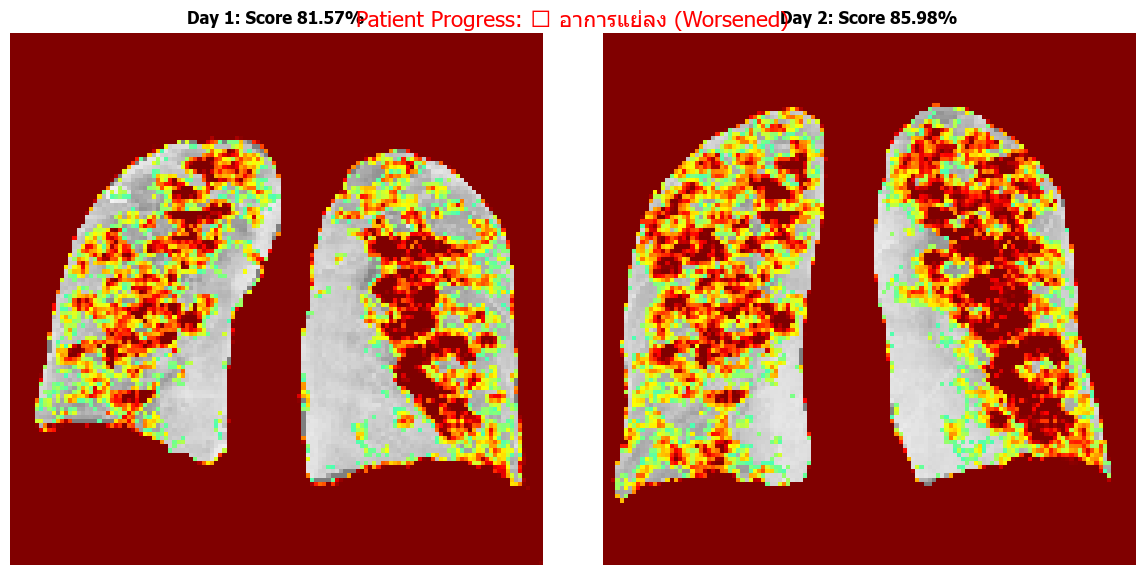


👤 ผู้ป่วย ID: 2283
   📅 เทียบ: 2283_cxr_novap_20251004_1.jpg vs 2283_cxr_novap_20251009_1.jpg
🔄 กำลังเปรียบเทียบอาการ...
📅 Day 1: 2283_cxr_novap_20251004_1.jpg
📅 Day 2: 2283_cxr_novap_20251009_1.jpg

📊 ผลลัพธ์:
   - คะแนน Day 1: 86.60%
   - คะแนน Day 2: 87.83%
   - สรุป: ❌ อาการแย่ลง (Worsened) (+1.23%)


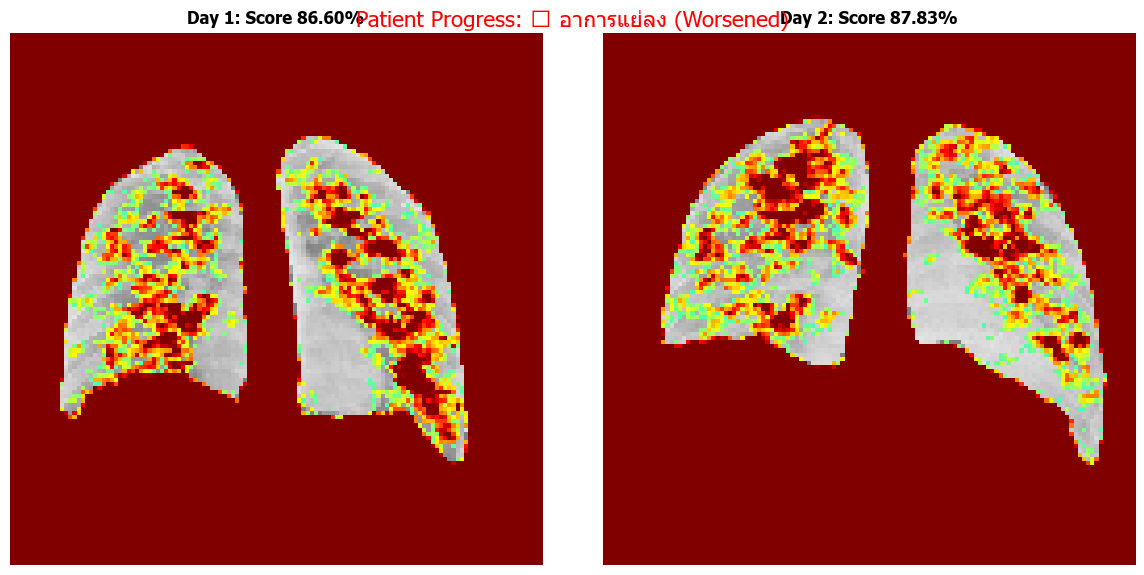


👤 ผู้ป่วย ID: 2285
   📅 เทียบ: 2285_cxr_novap_20251005_1.jpg vs 2285_cxr_novap_20251010_1.jpg
🔄 กำลังเปรียบเทียบอาการ...
📅 Day 1: 2285_cxr_novap_20251005_1.jpg
📅 Day 2: 2285_cxr_novap_20251010_1.jpg

📊 ผลลัพธ์:
   - คะแนน Day 1: 93.51%
   - คะแนน Day 2: 86.04%
   - สรุป: ✅ อาการดีขึ้น (Improved) (-7.47%)


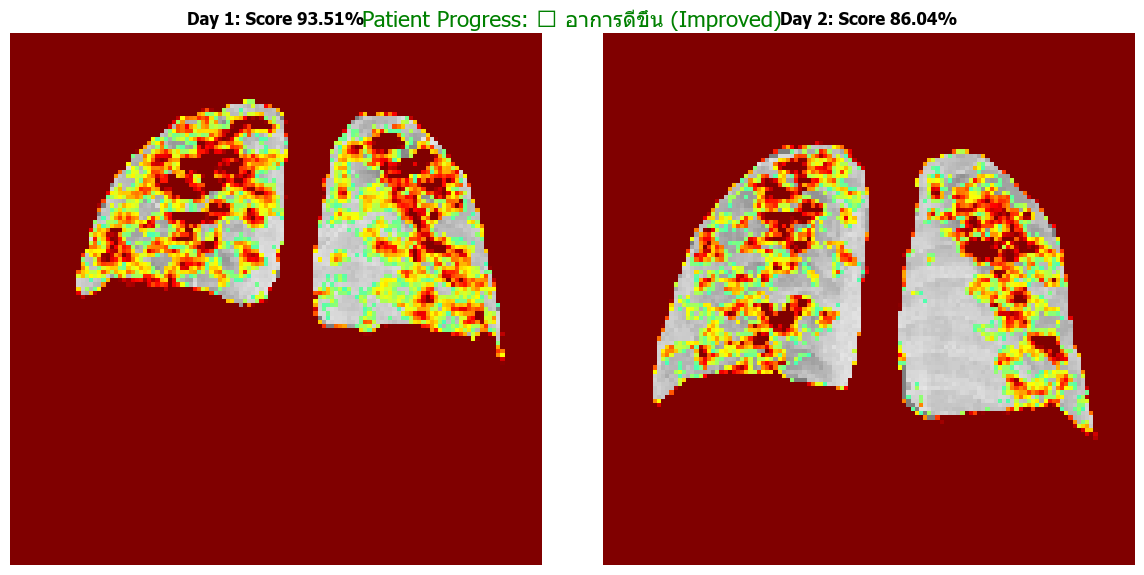


👤 ผู้ป่วย ID: 2286
   📅 เทียบ: 2286_cxr_novap_20251005_1.jpg vs 2286_cxr_novap_20251014_1.jpg
🔄 กำลังเปรียบเทียบอาการ...
📅 Day 1: 2286_cxr_novap_20251005_1.jpg
📅 Day 2: 2286_cxr_novap_20251014_1.jpg

📊 ผลลัพธ์:
   - คะแนน Day 1: 84.58%
   - คะแนน Day 2: 92.16%
   - สรุป: ❌ อาการแย่ลง (Worsened) (+7.58%)


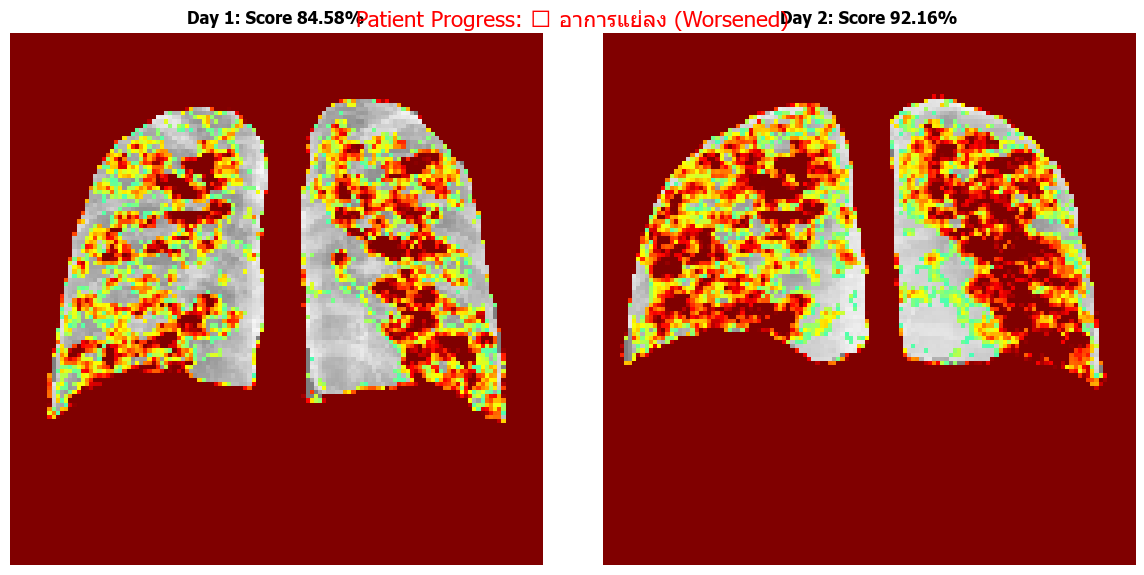


👤 ผู้ป่วย ID: 2288
   📅 เทียบ: 2288_cxr_novap_20251006_1.jpg vs 2288_cxr_novap_20251013_1.jpg
🔄 กำลังเปรียบเทียบอาการ...
📅 Day 1: 2288_cxr_novap_20251006_1.jpg
📅 Day 2: 2288_cxr_novap_20251013_1.jpg

📊 ผลลัพธ์:
   - คะแนน Day 1: 90.47%
   - คะแนน Day 2: 92.52%
   - สรุป: ❌ อาการแย่ลง (Worsened) (+2.06%)


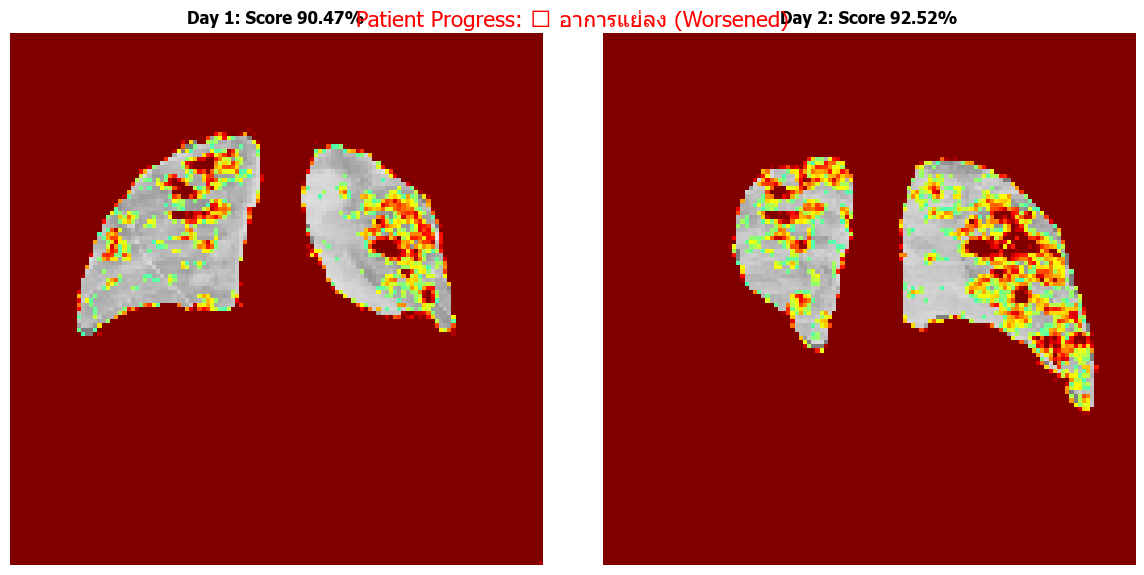


👤 ผู้ป่วย ID: 2289
   📅 เทียบ: 2289_cxr_novap_20251006_1.jpg vs 2289_cxr_novap_20251013_1.jpg
🔄 กำลังเปรียบเทียบอาการ...
📅 Day 1: 2289_cxr_novap_20251006_1.jpg
📅 Day 2: 2289_cxr_novap_20251013_1.jpg

📊 ผลลัพธ์:
   - คะแนน Day 1: 89.48%
   - คะแนน Day 2: 88.02%
   - สรุป: ✅ อาการดีขึ้น (Improved) (-1.46%)


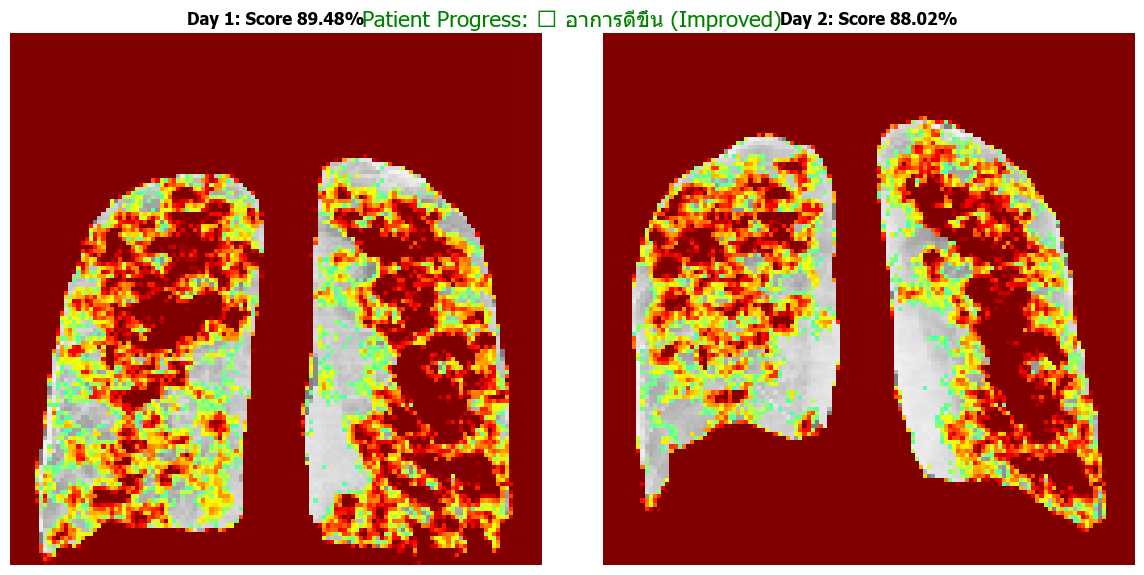


👤 ผู้ป่วย ID: 2290
   📅 เทียบ: 2290_cxr_novap_20251007_1.jpg vs 2290_cxr_novap_20251019_1.jpg
🔄 กำลังเปรียบเทียบอาการ...
📅 Day 1: 2290_cxr_novap_20251007_1.jpg
📅 Day 2: 2290_cxr_novap_20251019_1.jpg

📊 ผลลัพธ์:
   - คะแนน Day 1: 85.10%
   - คะแนน Day 2: 89.92%
   - สรุป: ❌ อาการแย่ลง (Worsened) (+4.82%)


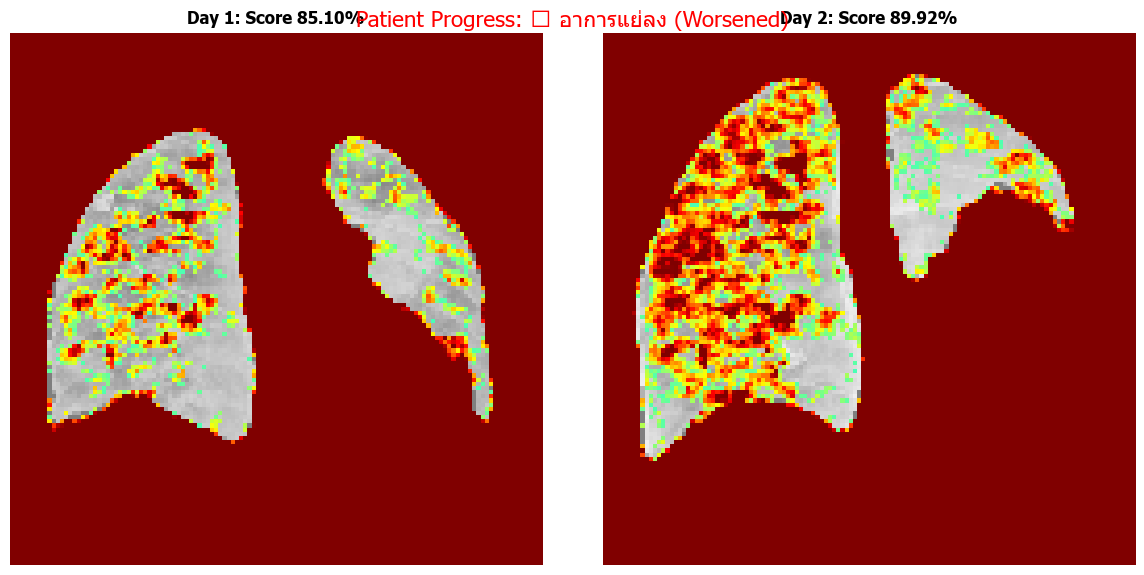


👤 ผู้ป่วย ID: 2299
   📅 เทียบ: 2299_cxr_novap_20251011_1.jpg vs 2299_cxr_novap_20251012_1.jpg
🔄 กำลังเปรียบเทียบอาการ...
📅 Day 1: 2299_cxr_novap_20251011_1.jpg
📅 Day 2: 2299_cxr_novap_20251012_1.jpg

📊 ผลลัพธ์:
   - คะแนน Day 1: 87.21%
   - คะแนน Day 2: 87.81%
   - สรุป: ⚖️ อาการทรงตัว (Stable) (+0.60%)


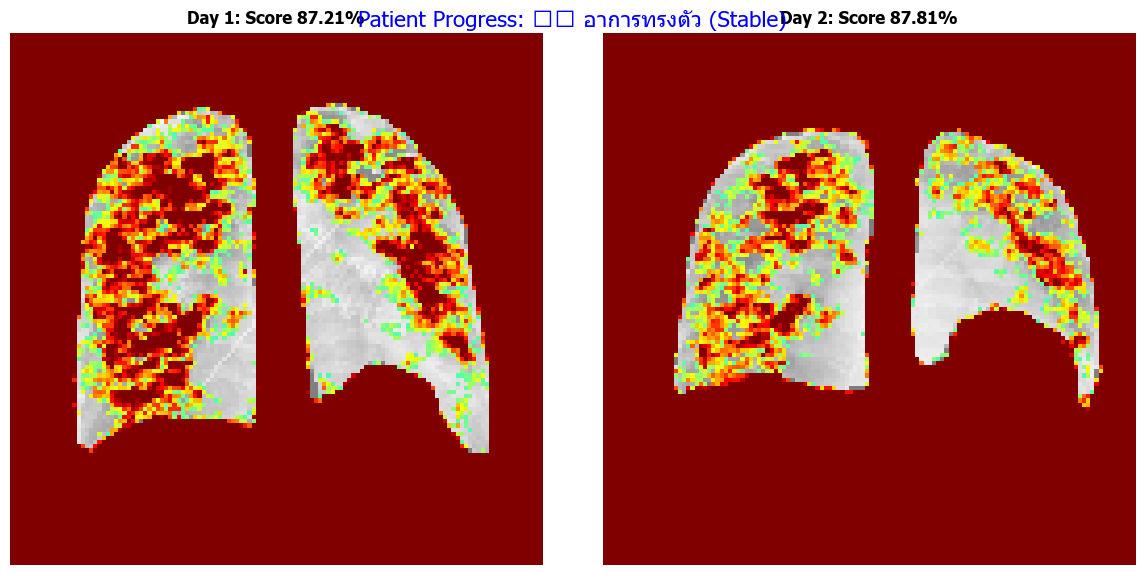


👤 ผู้ป่วย ID: 2300
   📅 เทียบ: 2300_cxr_novap_20251012_1.jpg vs 2300_cxr_novap_20251025_1.jpg
🔄 กำลังเปรียบเทียบอาการ...
📅 Day 1: 2300_cxr_novap_20251012_1.jpg
📅 Day 2: 2300_cxr_novap_20251025_1.jpg

📊 ผลลัพธ์:
   - คะแนน Day 1: 88.78%
   - คะแนน Day 2: 90.01%
   - สรุป: ❌ อาการแย่ลง (Worsened) (+1.24%)


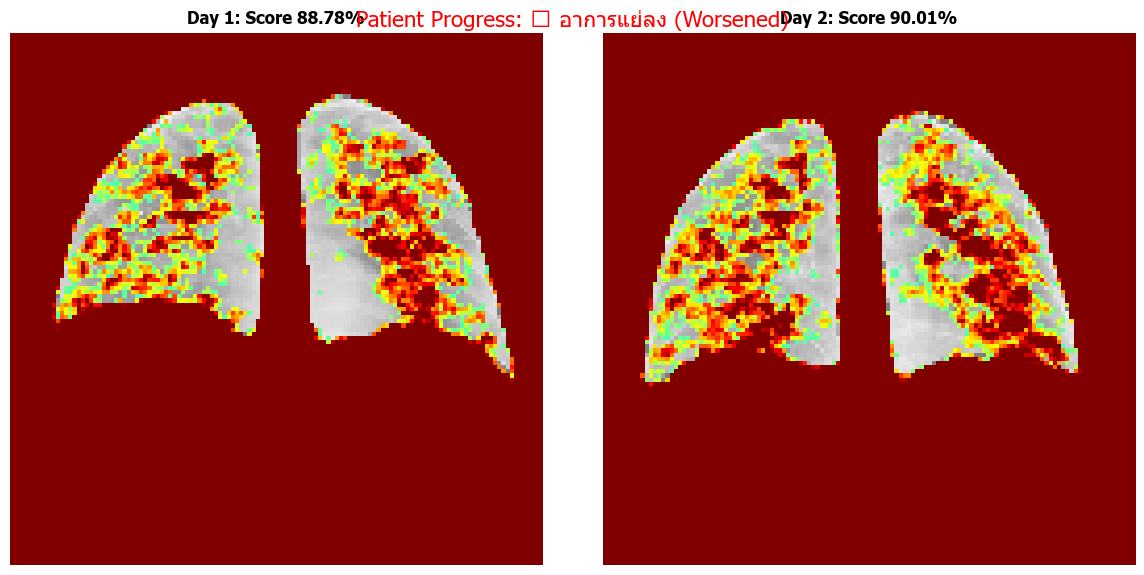


👤 ผู้ป่วย ID: 2303
   📅 เทียบ: 2303_cxr_novap_20251014_1.jpg vs 2303_cxr_novap_20251016_1.jpg
🔄 กำลังเปรียบเทียบอาการ...
📅 Day 1: 2303_cxr_novap_20251014_1.jpg
📅 Day 2: 2303_cxr_novap_20251016_1.jpg

📊 ผลลัพธ์:
   - คะแนน Day 1: 87.98%
   - คะแนน Day 2: 84.20%
   - สรุป: ✅ อาการดีขึ้น (Improved) (-3.78%)


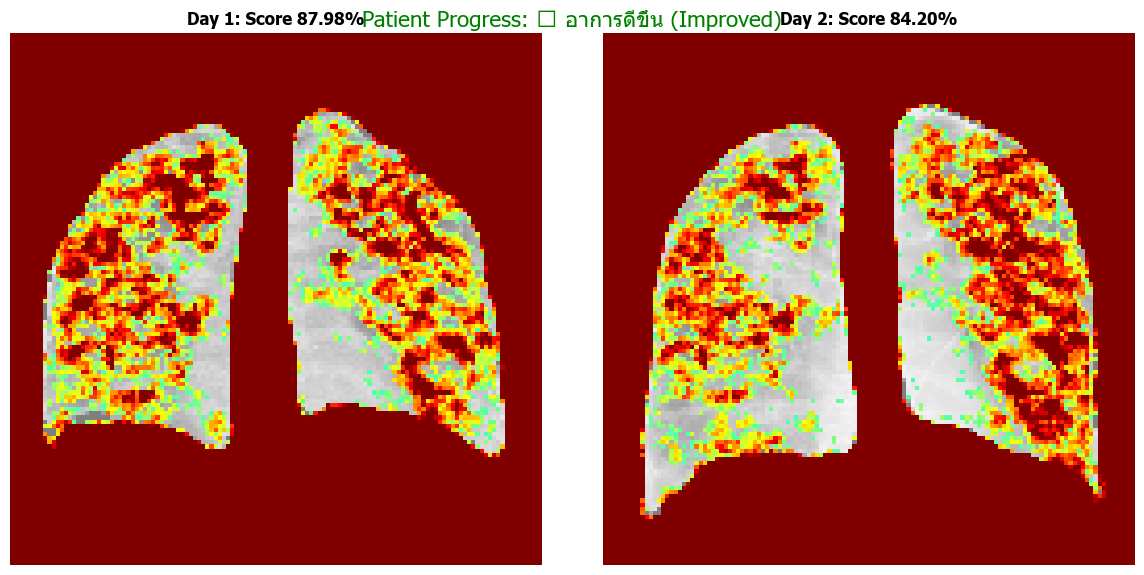


👤 ผู้ป่วย ID: 2304
   📅 เทียบ: 2304_cxr_novap_20251014_1.jpg vs 2304_cxr_novap_20251021_1.jpg
🔄 กำลังเปรียบเทียบอาการ...
📅 Day 1: 2304_cxr_novap_20251014_1.jpg
📅 Day 2: 2304_cxr_novap_20251021_1.jpg

📊 ผลลัพธ์:
   - คะแนน Day 1: 86.80%
   - คะแนน Day 2: 89.69%
   - สรุป: ❌ อาการแย่ลง (Worsened) (+2.88%)


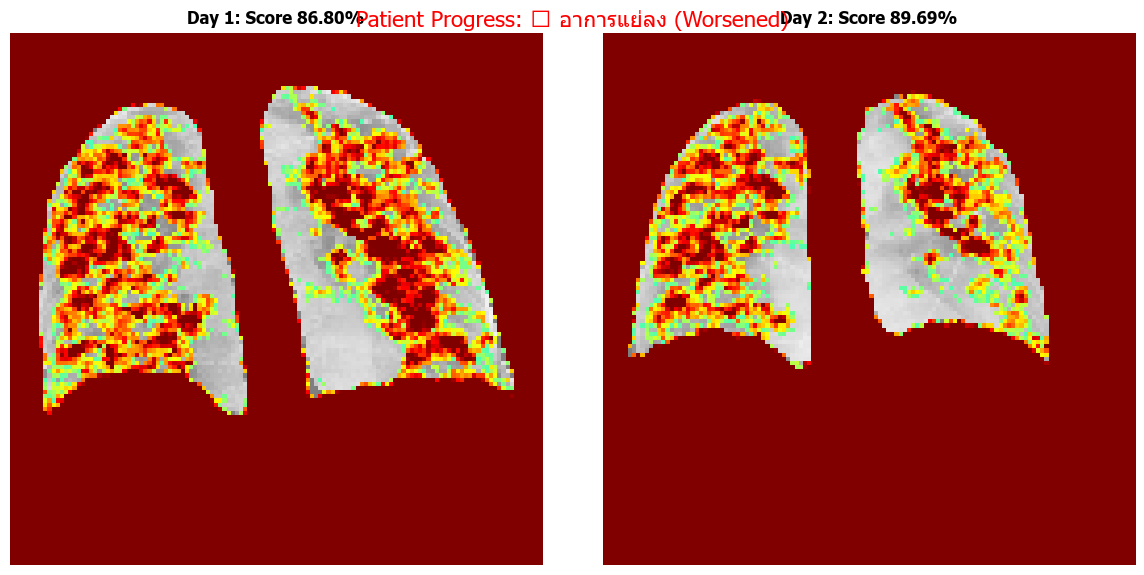


👤 ผู้ป่วย ID: 2310
   📅 เทียบ: 2310_cxr_novap_20251015_1.jpg vs 2310_cxr_novap_20251015_2.jpg
🔄 กำลังเปรียบเทียบอาการ...
📅 Day 1: 2310_cxr_novap_20251015_1.jpg
📅 Day 2: 2310_cxr_novap_20251015_2.jpg

📊 ผลลัพธ์:
   - คะแนน Day 1: 85.53%
   - คะแนน Day 2: 86.39%
   - สรุป: ⚖️ อาการทรงตัว (Stable) (+0.86%)


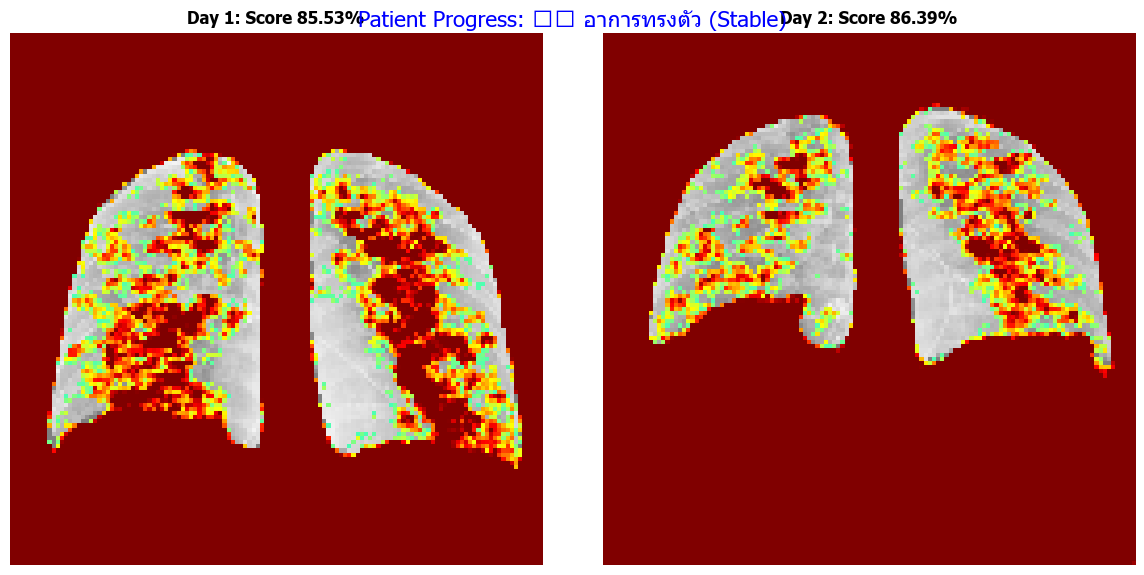


👤 ผู้ป่วย ID: 2312
   📅 เทียบ: 2312_cxr_novap_20251016_1.jpg vs 2312_cxr_novap_20251021_2.jpg
🔄 กำลังเปรียบเทียบอาการ...
📅 Day 1: 2312_cxr_novap_20251016_1.jpg
📅 Day 2: 2312_cxr_novap_20251021_2.jpg

📊 ผลลัพธ์:
   - คะแนน Day 1: 91.75%
   - คะแนน Day 2: 86.60%
   - สรุป: ✅ อาการดีขึ้น (Improved) (-5.15%)


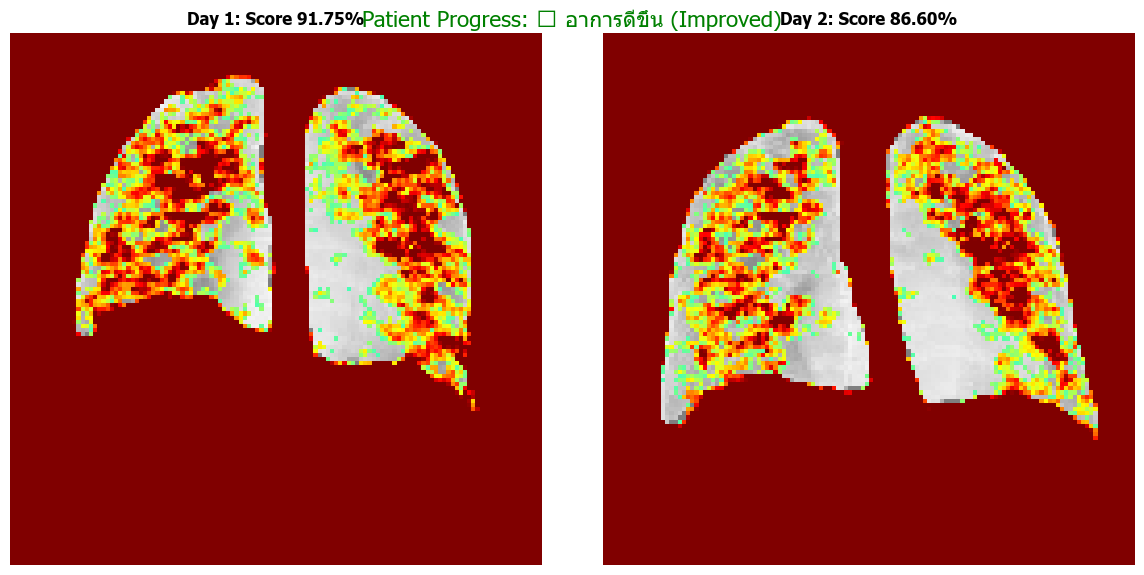


👤 ผู้ป่วย ID: 2315
   📅 เทียบ: 2315_cxr_novap_20251011_1.jpg vs 2315_cxr_novap_20251023_1.jpg
🔄 กำลังเปรียบเทียบอาการ...
📅 Day 1: 2315_cxr_novap_20251011_1.jpg
📅 Day 2: 2315_cxr_novap_20251023_1.jpg

📊 ผลลัพธ์:
   - คะแนน Day 1: 86.85%
   - คะแนน Day 2: 84.83%
   - สรุป: ✅ อาการดีขึ้น (Improved) (-2.03%)


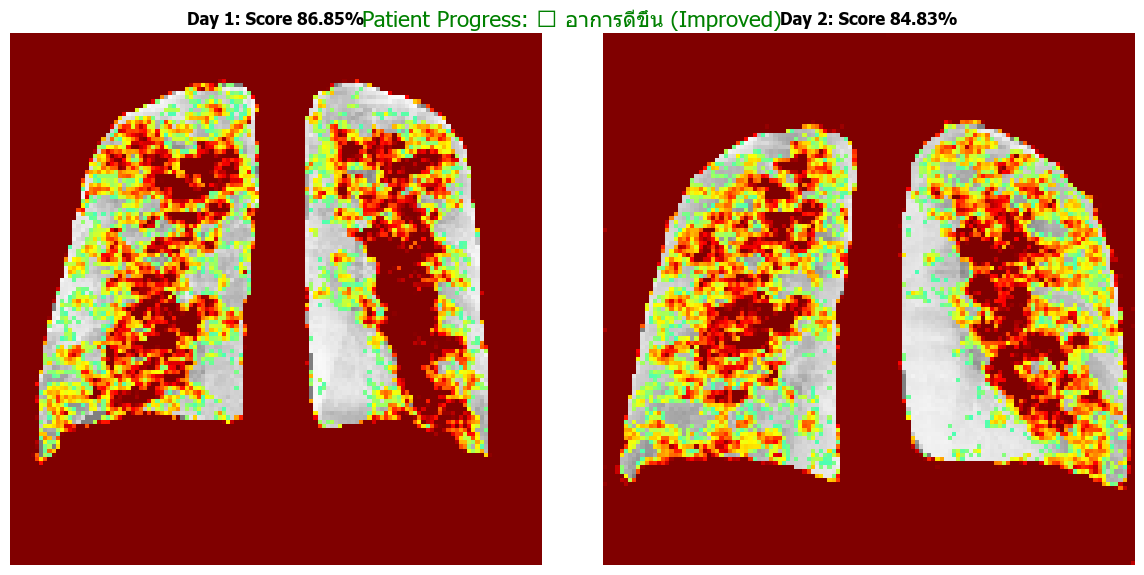


👤 ผู้ป่วย ID: 2316
   📅 เทียบ: 2316_cxr_novap_20251018_1.jpg vs 2316_cxr_novap_20251019_1.jpg
🔄 กำลังเปรียบเทียบอาการ...
📅 Day 1: 2316_cxr_novap_20251018_1.jpg
📅 Day 2: 2316_cxr_novap_20251019_1.jpg

📊 ผลลัพธ์:
   - คะแนน Day 1: 89.61%
   - คะแนน Day 2: 87.18%
   - สรุป: ✅ อาการดีขึ้น (Improved) (-2.44%)


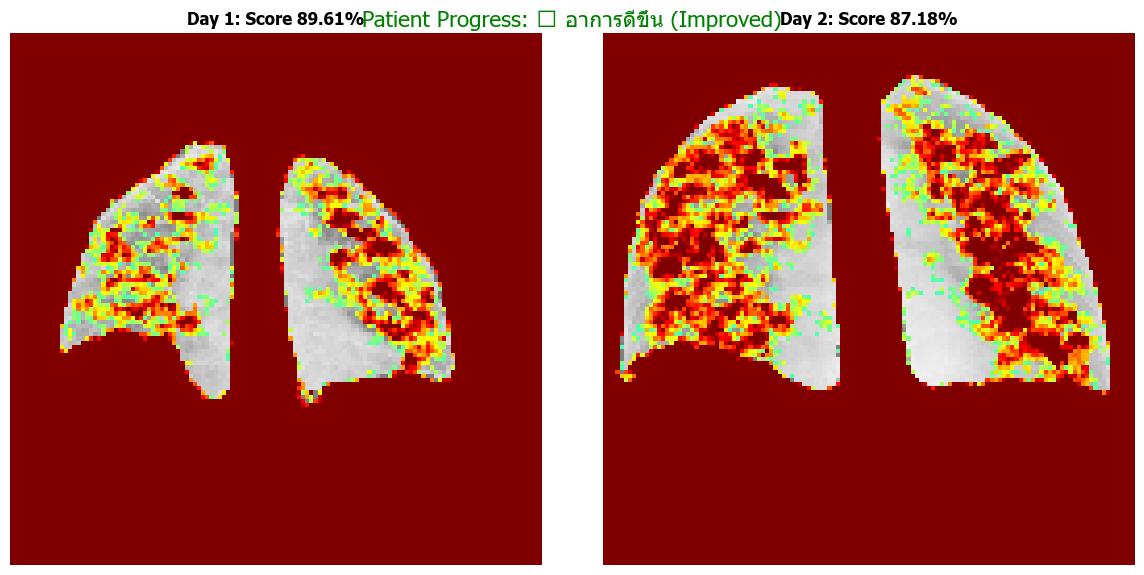


👤 ผู้ป่วย ID: 2317
   📅 เทียบ: 2317_cxr_novap_20251019_1.jpg vs 2317_cxr_novap_20251031_1.jpg
🔄 กำลังเปรียบเทียบอาการ...
📅 Day 1: 2317_cxr_novap_20251019_1.jpg
📅 Day 2: 2317_cxr_novap_20251031_1.jpg

📊 ผลลัพธ์:
   - คะแนน Day 1: 87.52%
   - คะแนน Day 2: 88.60%
   - สรุป: ❌ อาการแย่ลง (Worsened) (+1.07%)


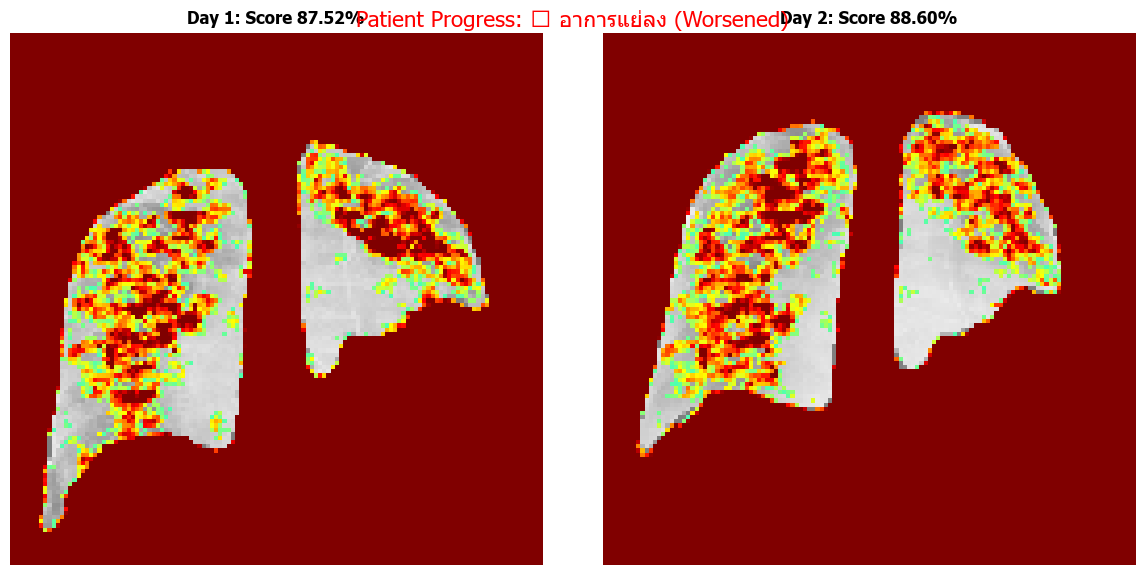


👤 ผู้ป่วย ID: 2320
   📅 เทียบ: 2320_cxr_novap_20251020_1.jpg vs 2320_cxr_novap_20251021_1.jpg
🔄 กำลังเปรียบเทียบอาการ...
📅 Day 1: 2320_cxr_novap_20251020_1.jpg
📅 Day 2: 2320_cxr_novap_20251021_1.jpg

📊 ผลลัพธ์:
   - คะแนน Day 1: 81.16%
   - คะแนน Day 2: 81.41%
   - สรุป: ⚖️ อาการทรงตัว (Stable) (+0.25%)


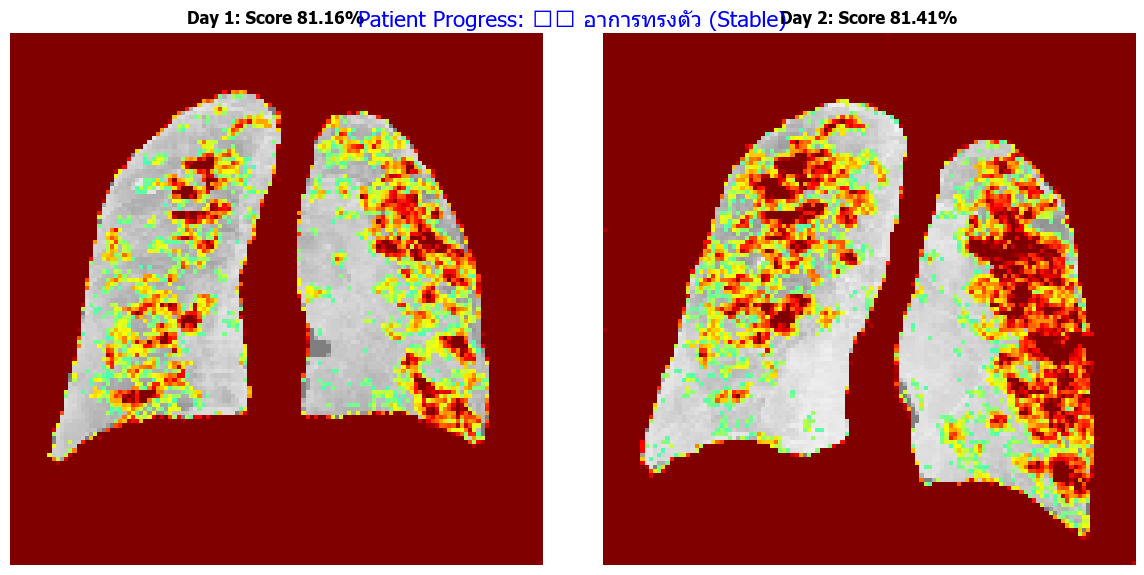


👤 ผู้ป่วย ID: 2321
   📅 เทียบ: 2321_cxr_novap_20251019_1.jpg vs 2321_cxr_novap_20251027_1.jpg
🔄 กำลังเปรียบเทียบอาการ...
📅 Day 1: 2321_cxr_novap_20251019_1.jpg
📅 Day 2: 2321_cxr_novap_20251027_1.jpg

📊 ผลลัพธ์:
   - คะแนน Day 1: 87.99%
   - คะแนน Day 2: 93.48%
   - สรุป: ❌ อาการแย่ลง (Worsened) (+5.48%)


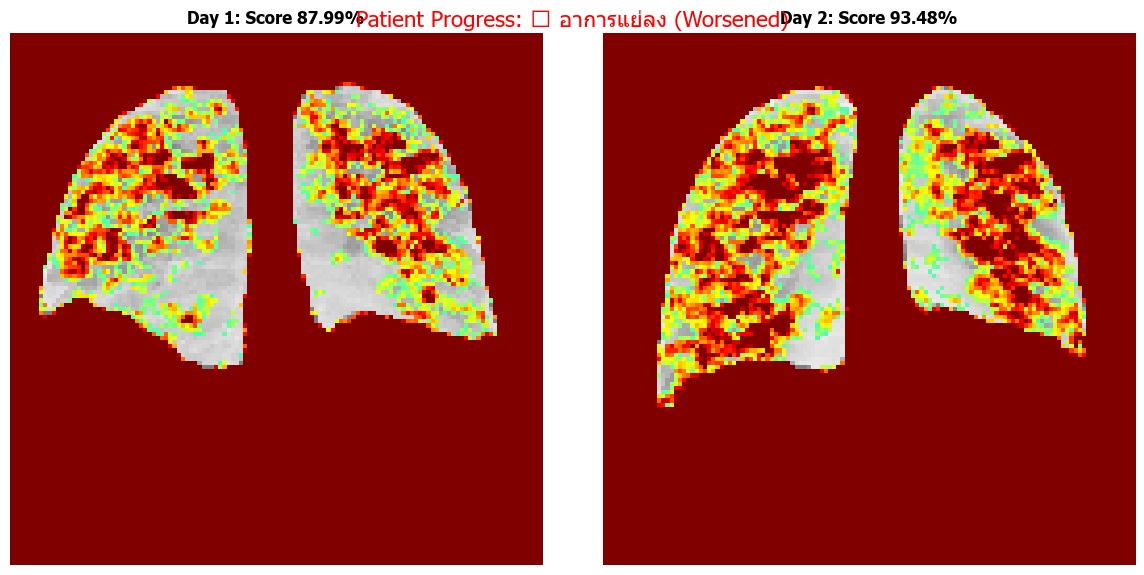


👤 ผู้ป่วย ID: 2328
   📅 เทียบ: 2328_cxr_novap_20251021_1.jpg vs 2328_cxr_novap_20251029_1.jpg
🔄 กำลังเปรียบเทียบอาการ...
📅 Day 1: 2328_cxr_novap_20251021_1.jpg
📅 Day 2: 2328_cxr_novap_20251029_1.jpg

📊 ผลลัพธ์:
   - คะแนน Day 1: 86.68%
   - คะแนน Day 2: 86.99%
   - สรุป: ⚖️ อาการทรงตัว (Stable) (+0.32%)


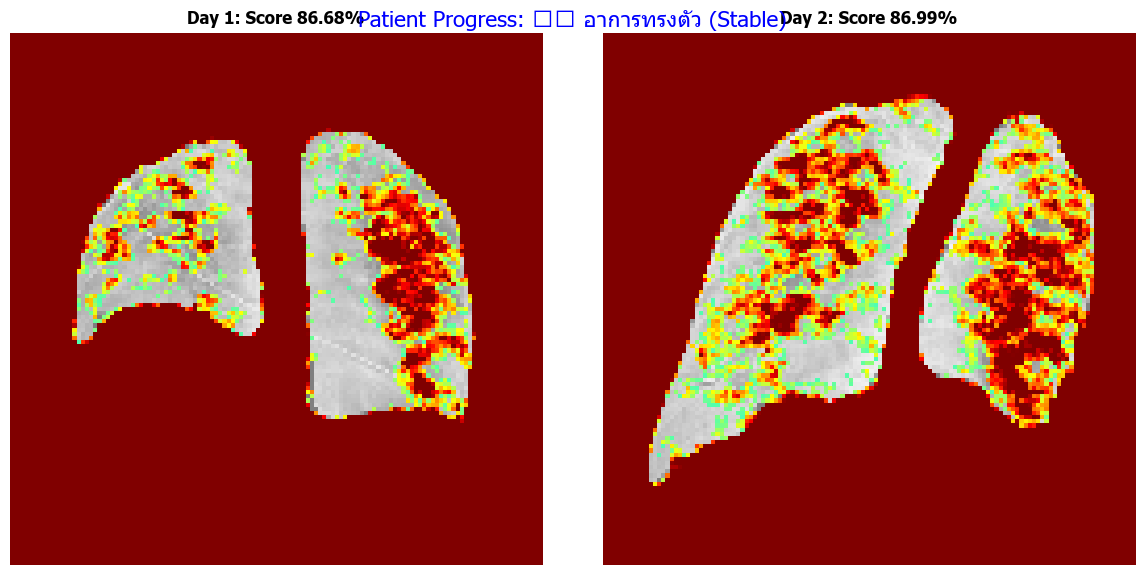


👤 ผู้ป่วย ID: 2336
   📅 เทียบ: 2336_cxr_novap_20251024_1.jpg vs 2336_cxr_novap_20251029_1.jpg
🔄 กำลังเปรียบเทียบอาการ...
📅 Day 1: 2336_cxr_novap_20251024_1.jpg
📅 Day 2: 2336_cxr_novap_20251029_1.jpg

📊 ผลลัพธ์:
   - คะแนน Day 1: 88.96%
   - คะแนน Day 2: 92.21%
   - สรุป: ❌ อาการแย่ลง (Worsened) (+3.25%)


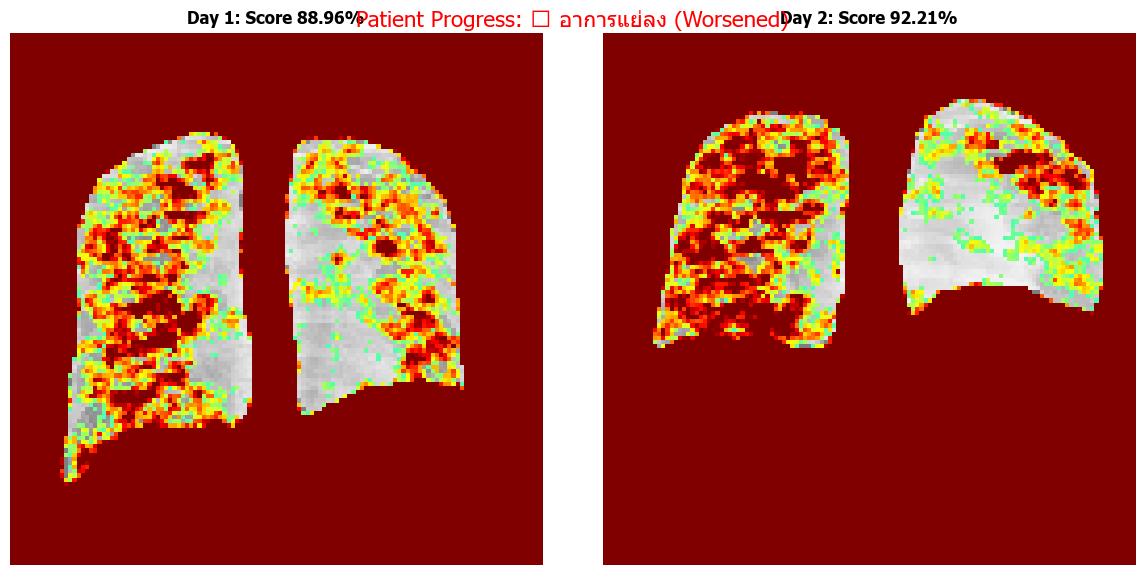


👤 ผู้ป่วย ID: 2337
   📅 เทียบ: 2337_cxr_novap_20251024_1.jpg vs 2337_cxr_novap_20251027_1.jpg
🔄 กำลังเปรียบเทียบอาการ...
📅 Day 1: 2337_cxr_novap_20251024_1.jpg
📅 Day 2: 2337_cxr_novap_20251027_1.jpg

📊 ผลลัพธ์:
   - คะแนน Day 1: 88.49%
   - คะแนน Day 2: 88.67%
   - สรุป: ⚖️ อาการทรงตัว (Stable) (+0.18%)


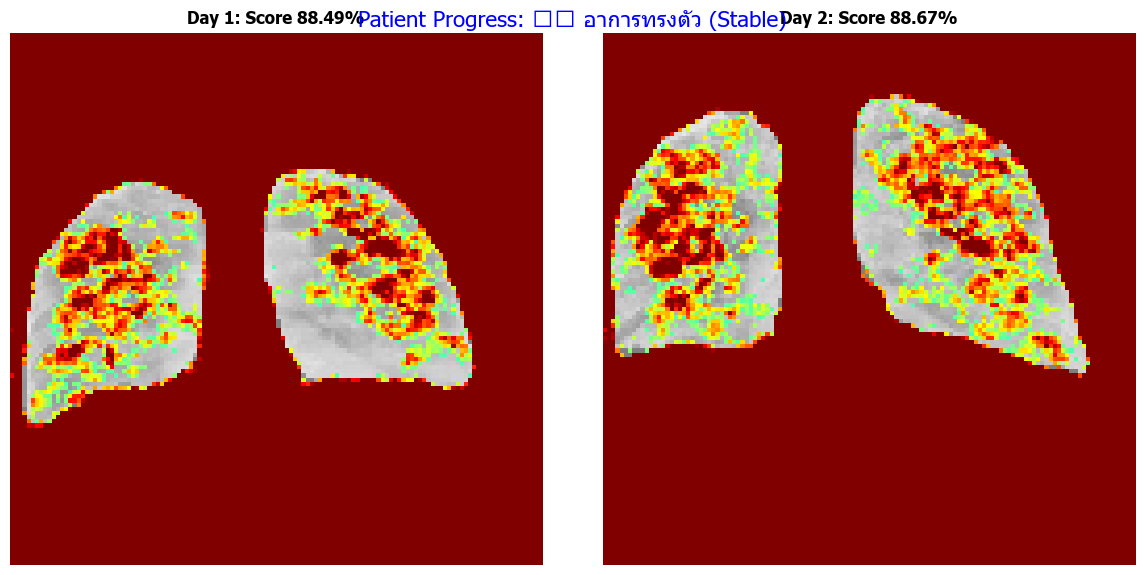


👤 ผู้ป่วย ID: 2338
   📅 เทียบ: 2338_cxr_novap_20251025_1.jpg vs 2338_cxr_novap_20251030_1.jpg
🔄 กำลังเปรียบเทียบอาการ...
📅 Day 1: 2338_cxr_novap_20251025_1.jpg
📅 Day 2: 2338_cxr_novap_20251030_1.jpg

📊 ผลลัพธ์:
   - คะแนน Day 1: 84.11%
   - คะแนน Day 2: 88.54%
   - สรุป: ❌ อาการแย่ลง (Worsened) (+4.43%)


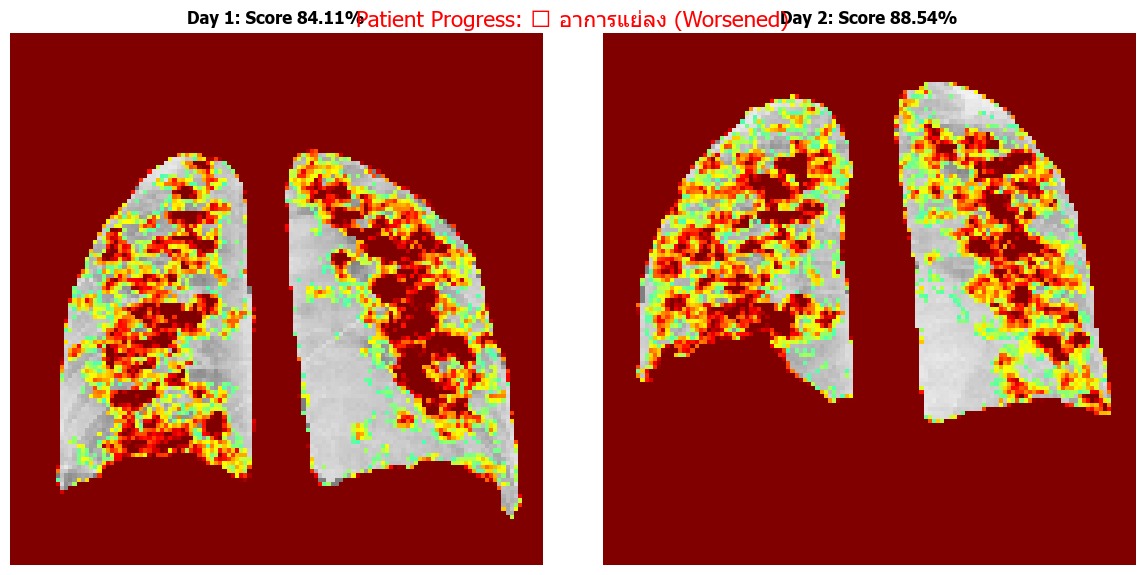

In [25]:
import os
import glob

def process_batch_patient_folders(root_dataset_path, model, scheduler):
    """
    วนลูปอ่านทุกโฟลเดอร์ใน dataset และเปรียบเทียบอาการ (ภาพแรก vs ภาพล่าสุด)
    """
    # กำหนดกลุ่มที่จะตรวจ
    classes = ['vap', 'novap']
    
    for class_name in classes:
        class_path = os.path.join(root_dataset_path, class_name)
        if not os.path.exists(class_path):
            print(f"⚠️ ไม่พบโฟลเดอร์: {class_path}")
            continue
            
        print(f"\n{'='*40}")
        print(f"🏥 กำลังตรวจสอบกลุ่ม: {class_name.upper()}")
        print(f"{'='*40}")
        
        # วนลูปหา ID ผู้ป่วย (เช่น 111, 222)
        patient_ids = [d for d in os.listdir(class_path) if os.path.isdir(os.path.join(class_path, d))]
        
        for pid in patient_ids:
            patient_path = os.path.join(class_path, pid)
            
            # อ่านไฟล์รูปทั้งหมดในโฟลเดอร์ผู้ป่วยคนนี้
            # รองรับทั้ง .jpg, .jpeg, .png
            types = ('*.jpg', '*.jpeg', '*.png') 
            images = []
            for files in types:
                images.extend(glob.glob(os.path.join(patient_path, files)))
            
            # เรียงลำดับตามชื่อไฟล์ (สมมติว่า img_001 มาก่อน img_002)
            images.sort()
            
            if len(images) < 2:
                print(f"⏩ ข้ามผู้ป่วย {pid}: มีรูปไม่พอเปรียบเทียบ ({len(images)} รูป)")
                continue
                
            # เลือกภาพแรก (Day 1) และภาพสุดท้าย (Day X) มาเทียบ
            img_day1 = images[0]
            img_day2 = images[-1] # เอาภาพล่าสุด
            
            print(f"\n👤 ผู้ป่วย ID: {pid}")
            print(f"   📅 เทียบ: {os.path.basename(img_day1)} vs {os.path.basename(img_day2)}")
            
            # เรียกฟังก์ชัน compare_progress ที่เราเขียนไว้ก่อนหน้านี้
            try:
                # ⚠️ ต้องรันฟังก์ชัน compare_progress ไว้ใน Memory ก่อนนะครับ
                compare_progress(img_day1, img_day2, model, scheduler)
            except Exception as e:
                print(f"❌ เกิดข้อผิดพลาดกับผู้ป่วย {pid}: {e}")

# =========================================================
# 🚀 วิธีใช้งาน
# =========================================================

# ระบุ Path ไปยังโฟลเดอร์ dataset ของคุณ
MY_DATASET_PATH = r"Chest xray CP class" # <-- แก้ตรงนี้ให้ตรงกับเครื่องคุณ

# สั่งรันเลย!
process_batch_patient_folders(MY_DATASET_PATH, model, noise_scheduler)